## Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
sys.path.insert(1, '../')
from glob import glob
import helpers.dataset_stats as ds
import helpers.convergence_stats as cs
import helpers.scalability_stats as ss
import helpers.sig_freq_itemsets_analyzer as sig
import helpers.numfreqitemsets_stats as ns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from itertools import combinations
import json
import pickle
import random

In [3]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.spines.top'] = 'False'
matplotlib.rcParams['axes.spines.right'] = 'False'
matplotlib.rcParams['axes.spines.left'] = 'False'
matplotlib.rcParams['axes.spines.bottom'] = 'False'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.grid.axis'] = 'y'
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20 
matplotlib.rcParams['legend.markerscale'] = 2
matplotlib.rcParams['legend.fontsize'] = 18 
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_64629/790388694.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [4]:
palette = sns.color_palette(['#9BA2FF', '#FFBC0A', '#AA5042', '#B0C4B1', 
                             '#002A22', '#FCB9B2', '#91CB3E', '#DE3C4B',
                             '#1CCAD8', '#7E6C6C'])

In [5]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [41]:
datasets = ['BMS1', 'BMS2', 'chess', 'foodmart', 'mushrooms', 
            'retail', 'kosarak', 'edit-iewikibooks', 
            'dbpedia-occupation', 'moreno_crime', 'wang-tripadvisor']

In [7]:
samplers = ['GmmtSampler', 'caterpillars.samplers.NaiveBJDMSampler', 
            'caterpillars.samplers.CurveballBJDMSampler']
sampler_names = {'GmmtSampler' : 'GMMT',
                 'diffusr.samplers.GmmtSampler': 'GMMT',
                 'caterpillars.samplers.NaiveBJDMSampler' : 'RSO',
                 'caterpillars.samplers.CurveballBJDMSampler' : 'ALICE'}

In [8]:
data_dir = '../datasets/'
fig_dir = '/Users/giulia/Documents/Projects/NullModels/random-butterflies/paper/figures/'

## Dataset Stats

In [43]:
dfs = []
for dataset in datasets:
    dfs.append(ds.get_dataset_stats(data_dir, dataset))
stats_df = pd.DataFrame(dfs)

In [44]:
stats_df.columns = ['DataSet', 'Transaction Num', 'Item Num', 
                    'Sum Transaction Lengths',   'AVG Transaction Length', 
                    'Density']

In [45]:
print(stats_df.to_latex(index=False, float_format="%.4f", column_format='lrrrrr',
                        caption='Statistics of the real datasets.',
                        label='tbl:datasets', position='!ht'))

\begin{table}[!ht]
\centering
\caption{Statistics of the real datasets.}
\label{tbl:datasets}
\begin{tabular}{lrrrrr}
\toprule
           DataSet &  Transaction Num &  Item Num &  Sum Transaction Lengths &  AVG Transaction Length &  Density \\
\midrule
              BMS1 &            59602 &       497 &                   149639 &                  2.5106 &   0.0051 \\
              BMS2 &            77512 &      3340 &                   358278 &                  4.6222 &   0.0014 \\
             chess &             3196 &        75 &                   118252 &                 37.0000 &   0.4933 \\
          foodmart &             4141 &      1559 &                    18319 &                  4.4238 &   0.0028 \\
         mushrooms &             8416 &       119 &                   193568 &                 23.0000 &   0.1933 \\
            retail &            88162 &     16470 &                   908576 &                 10.3058 &   0.0006 \\
           kosarak &           990002 &     4

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_64629/1553566010.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_df.to_latex(index=False, float_format="%.4f", column_format='lrrrrr',


### BJDM

In [46]:
num_squares = 80

267 3658


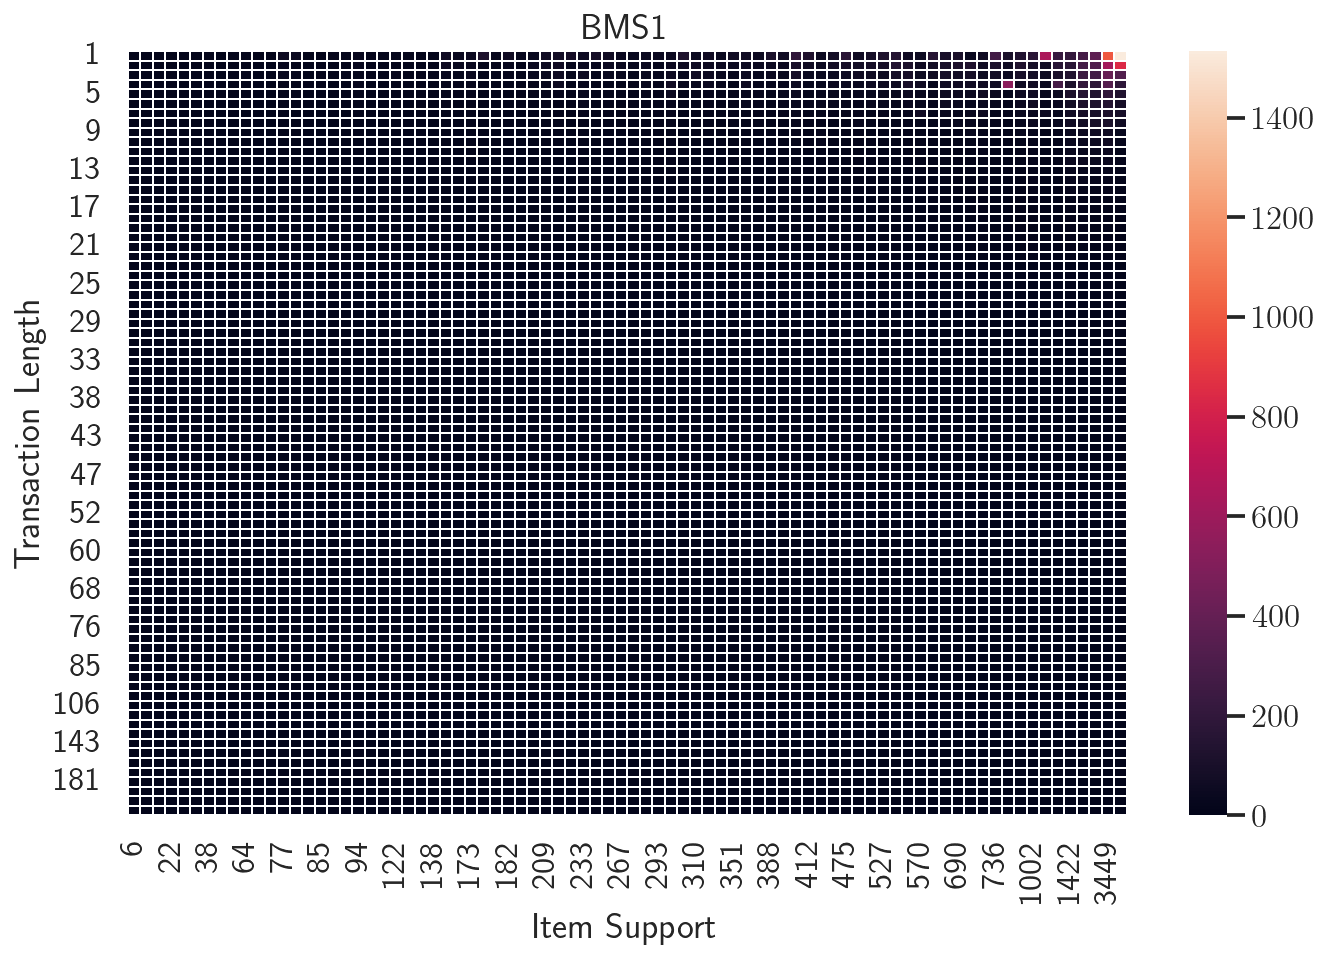

161 3766


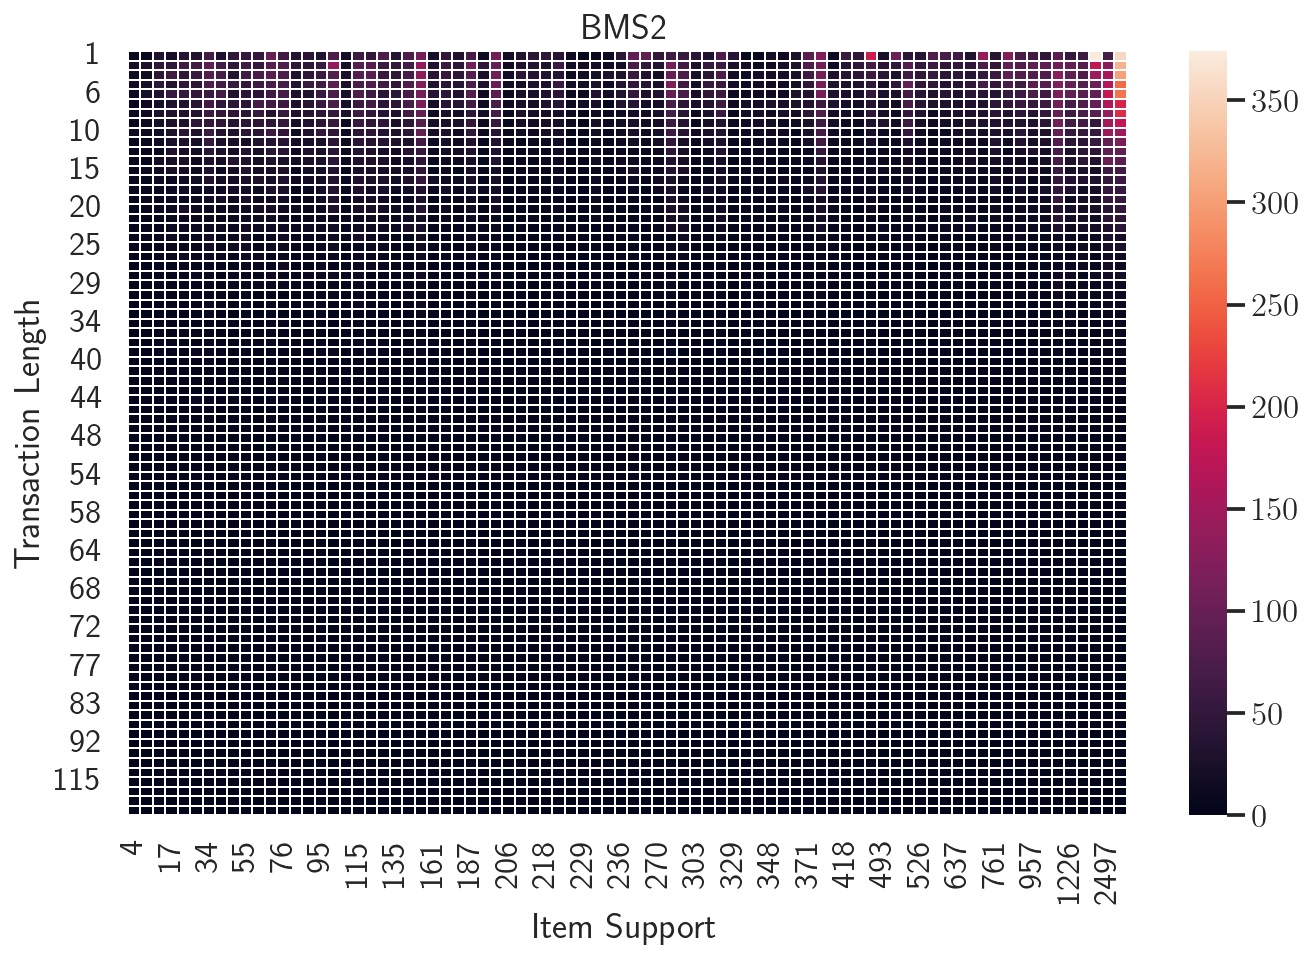

37 3195


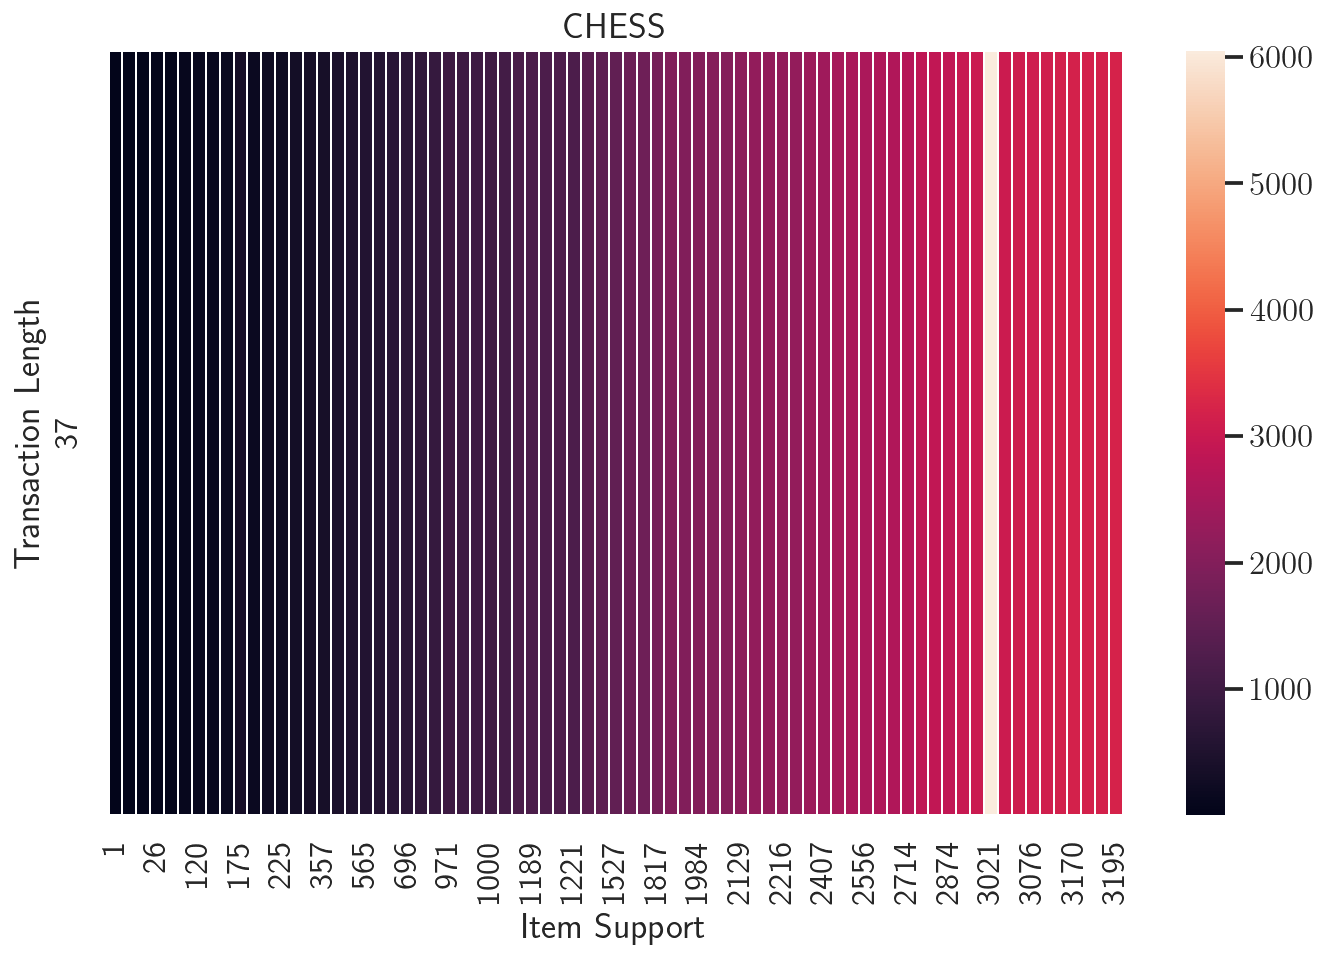

14 25


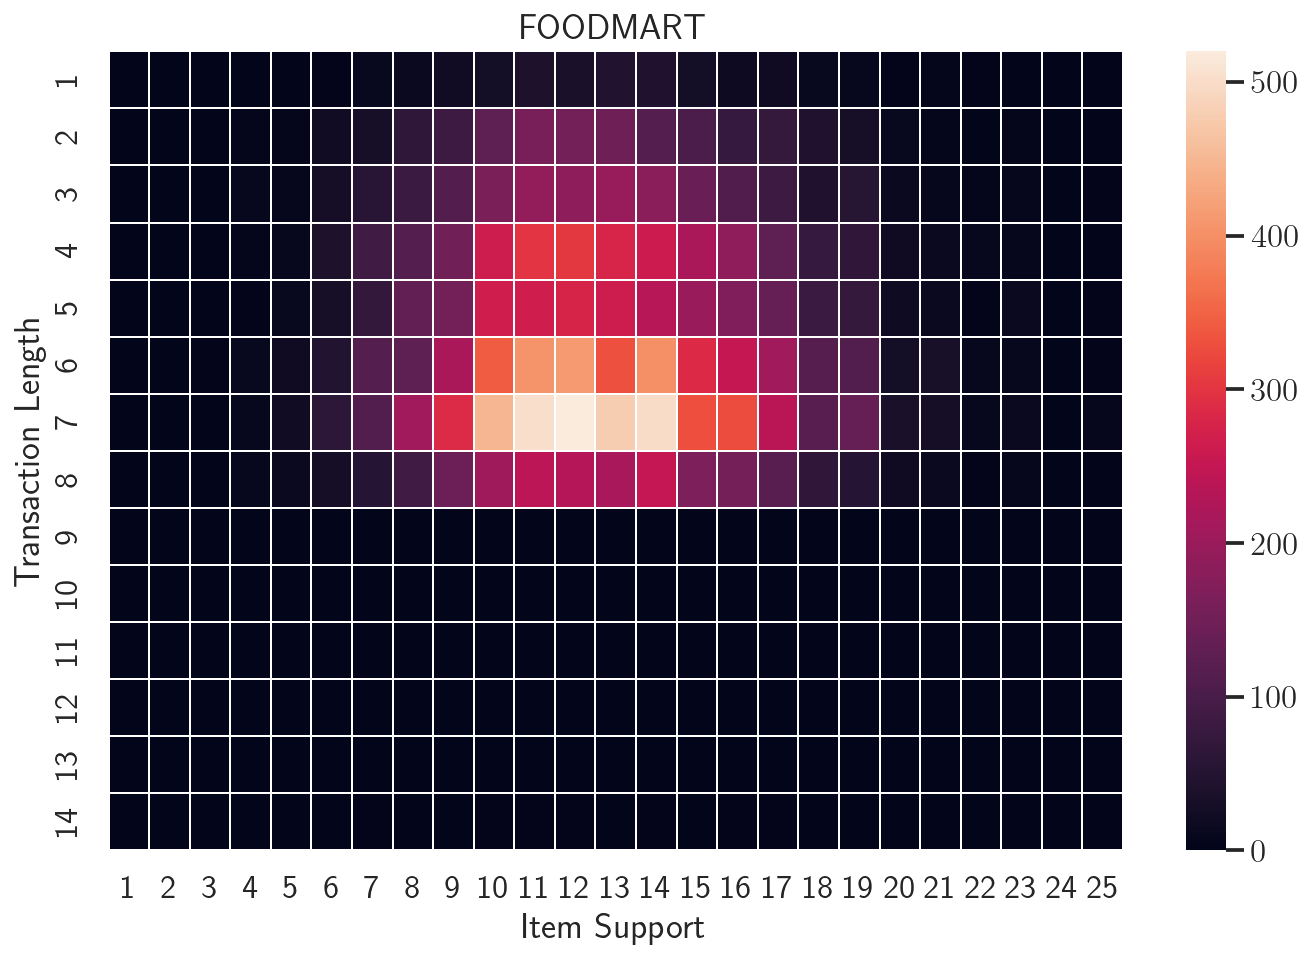

23 8416


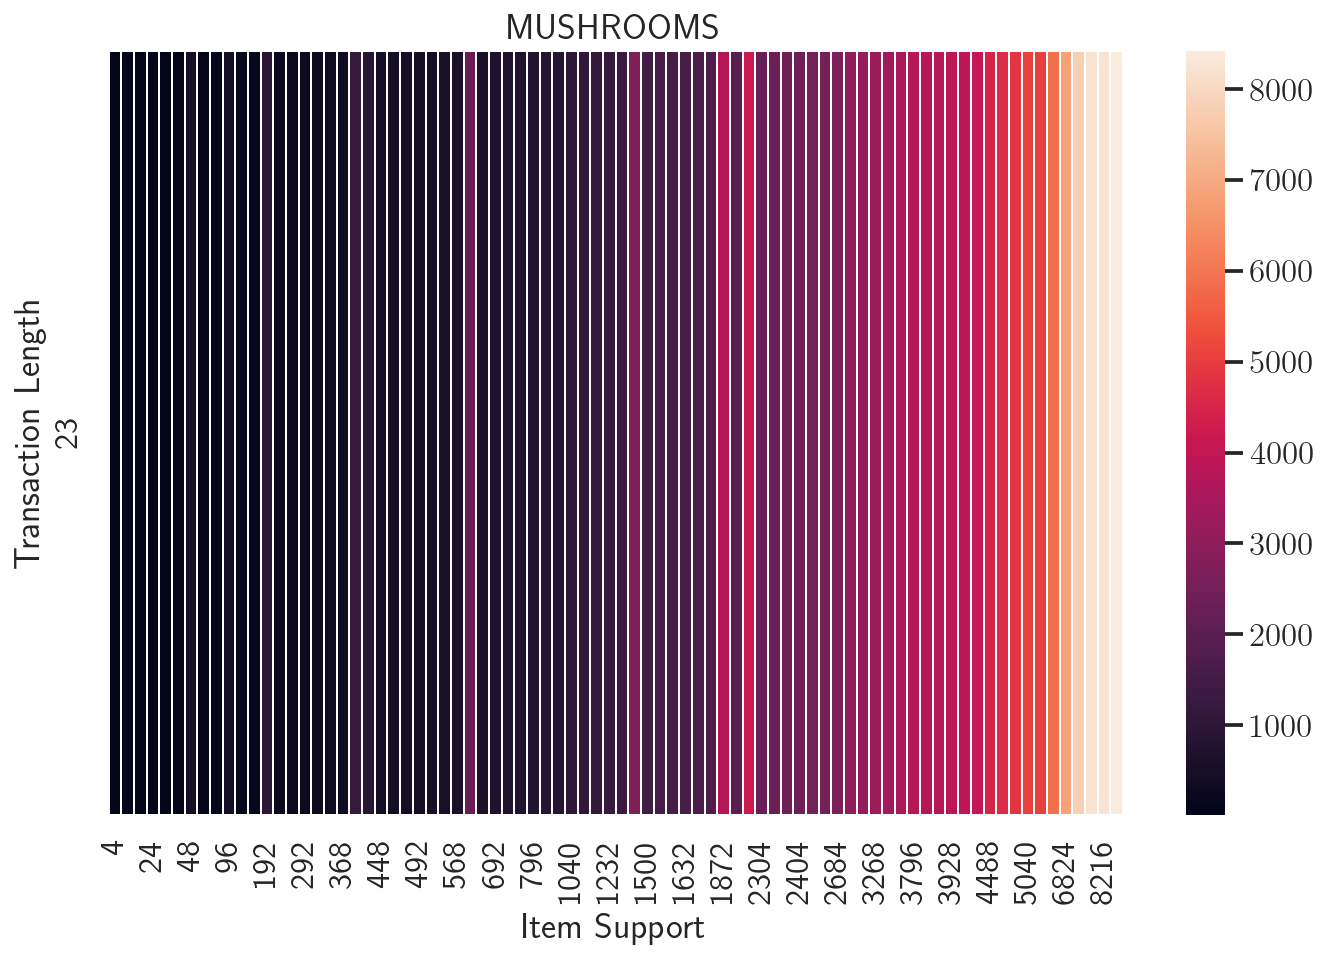

76 50675


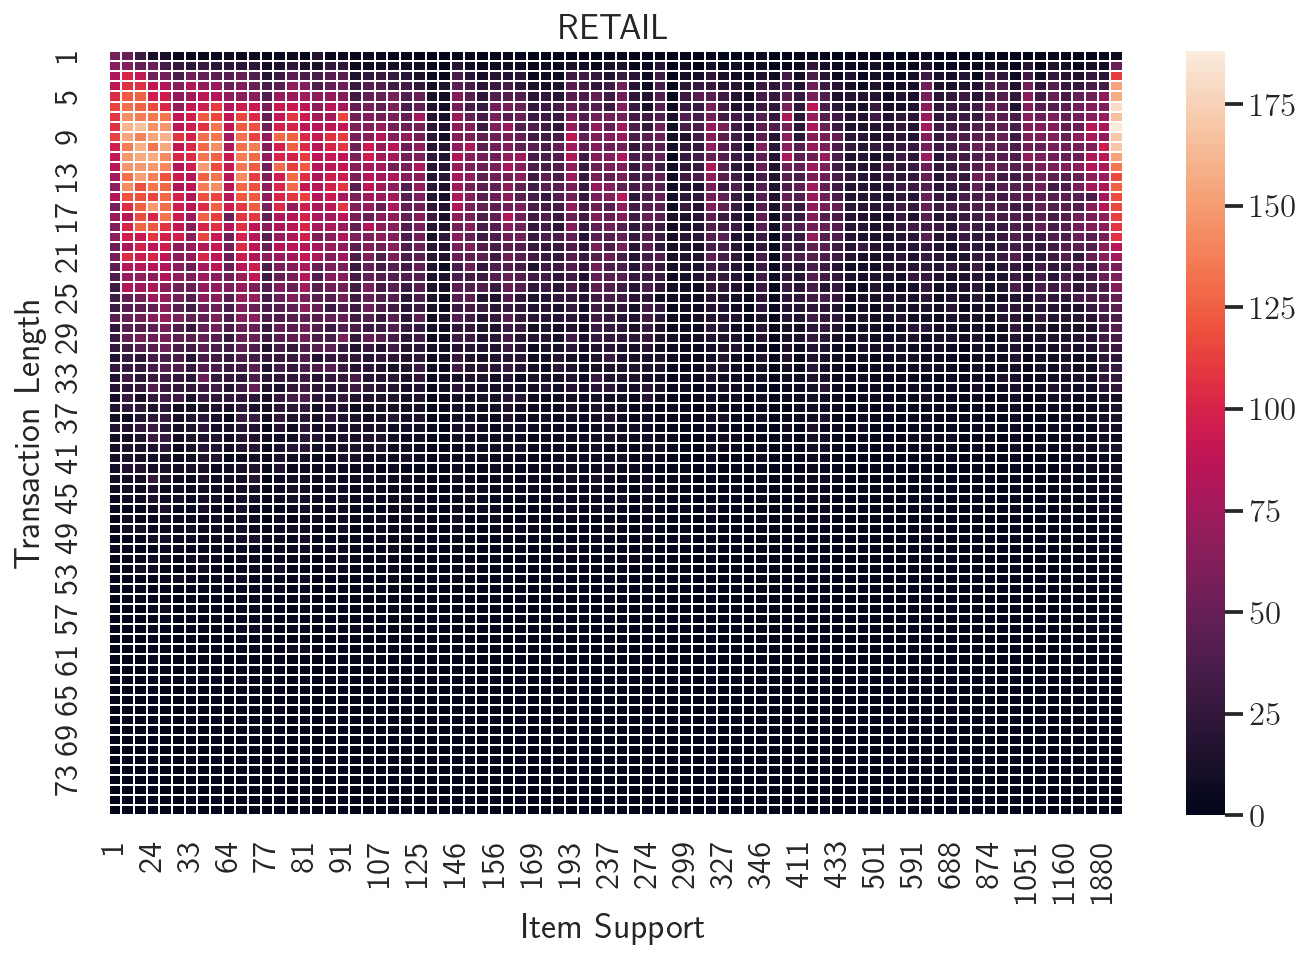

2498 601374


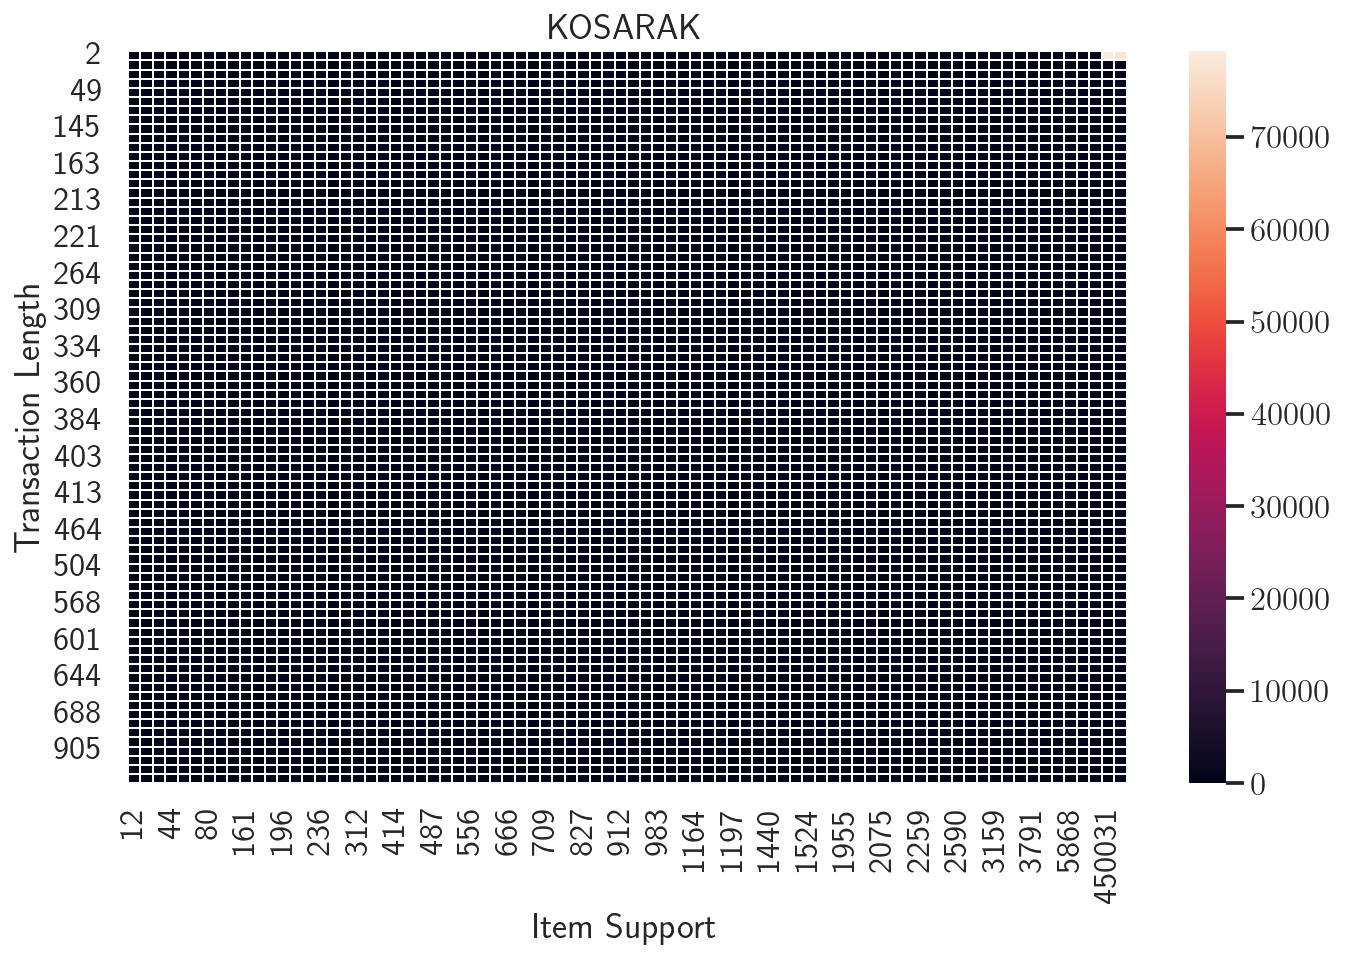

181 7


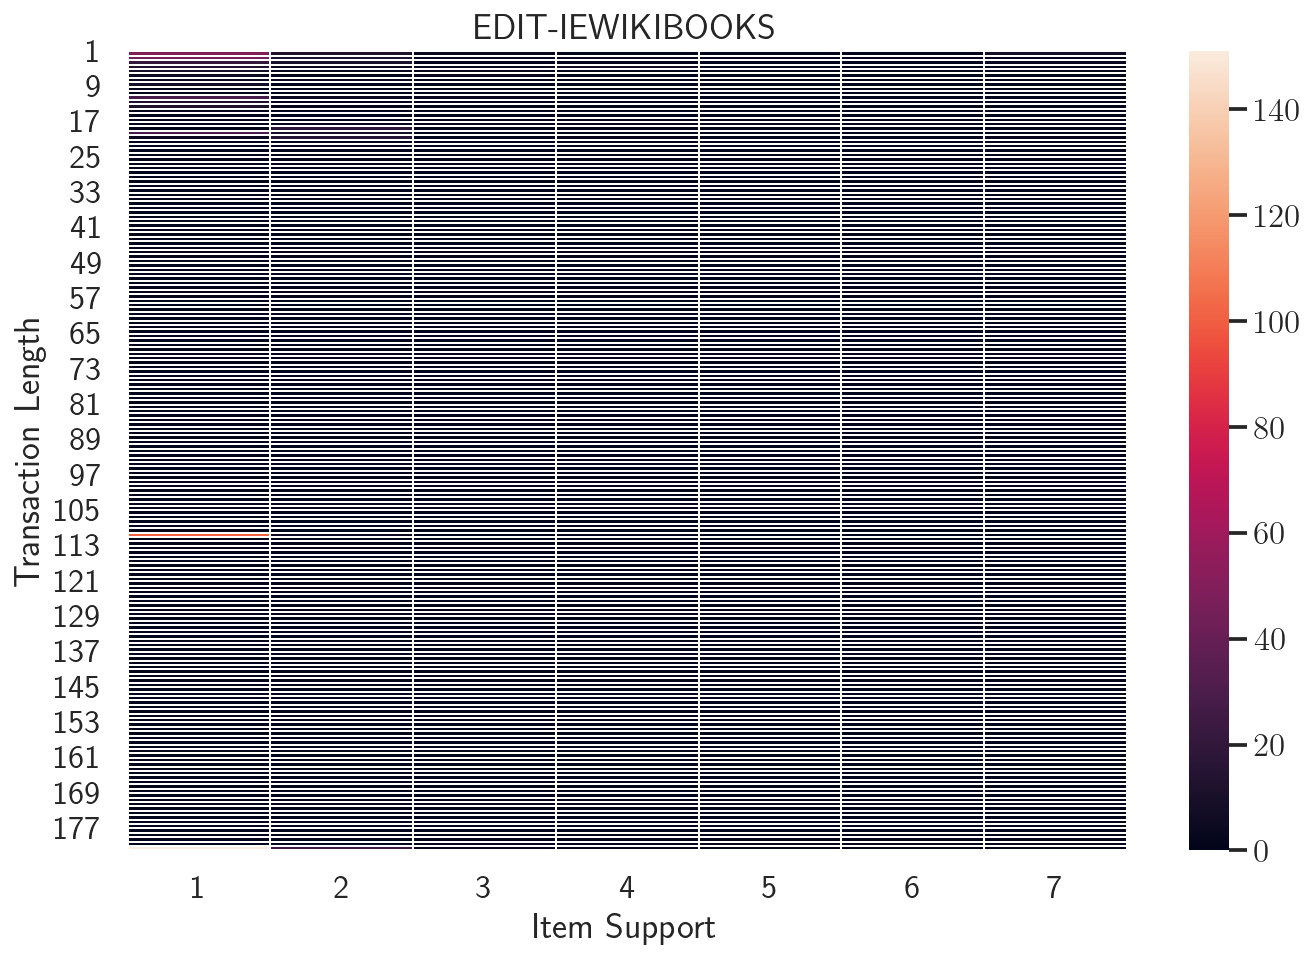

18 548


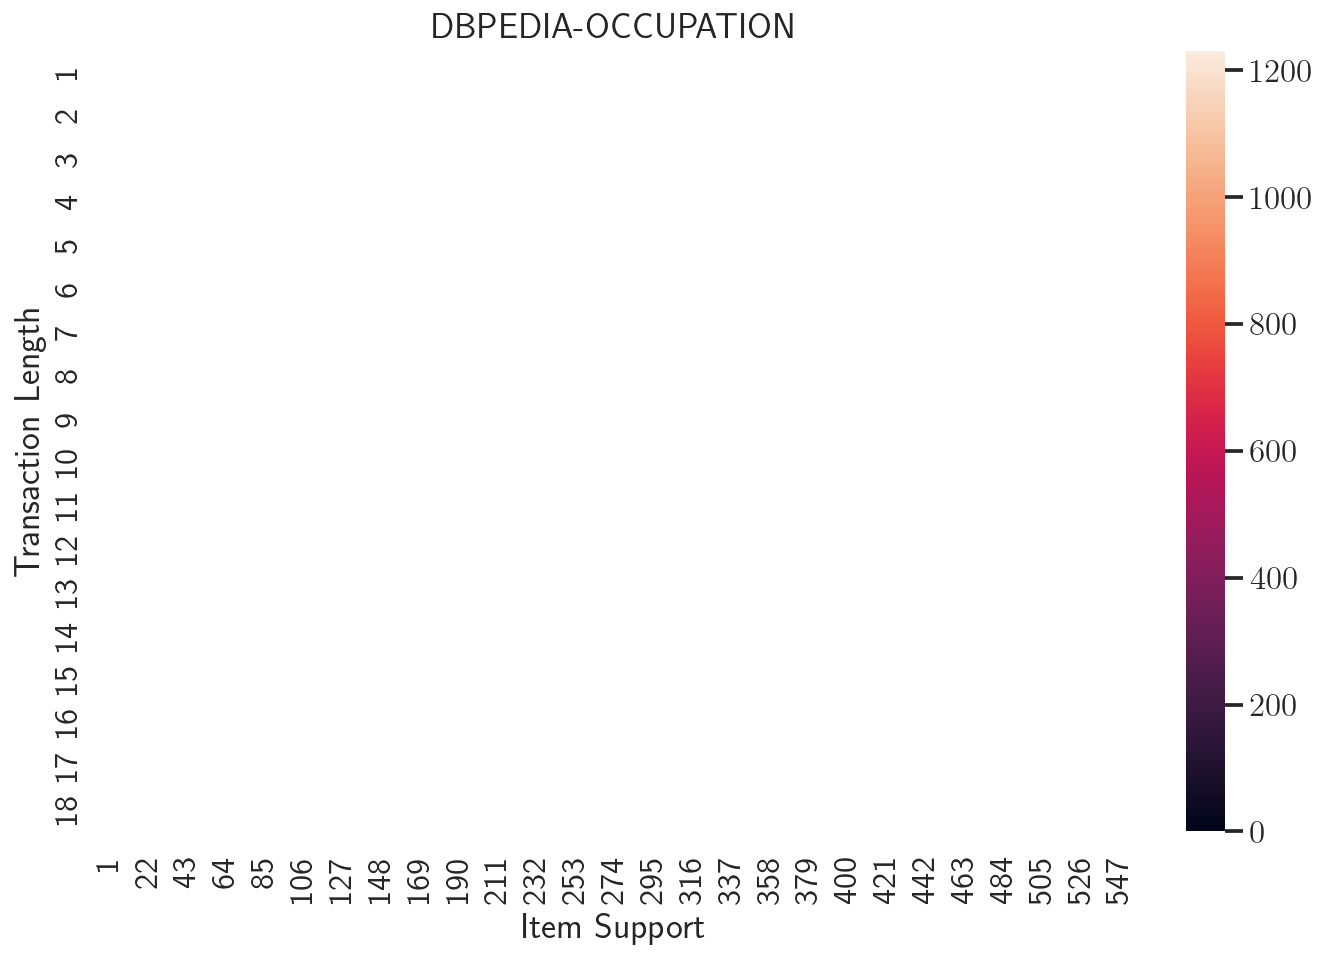

25 18


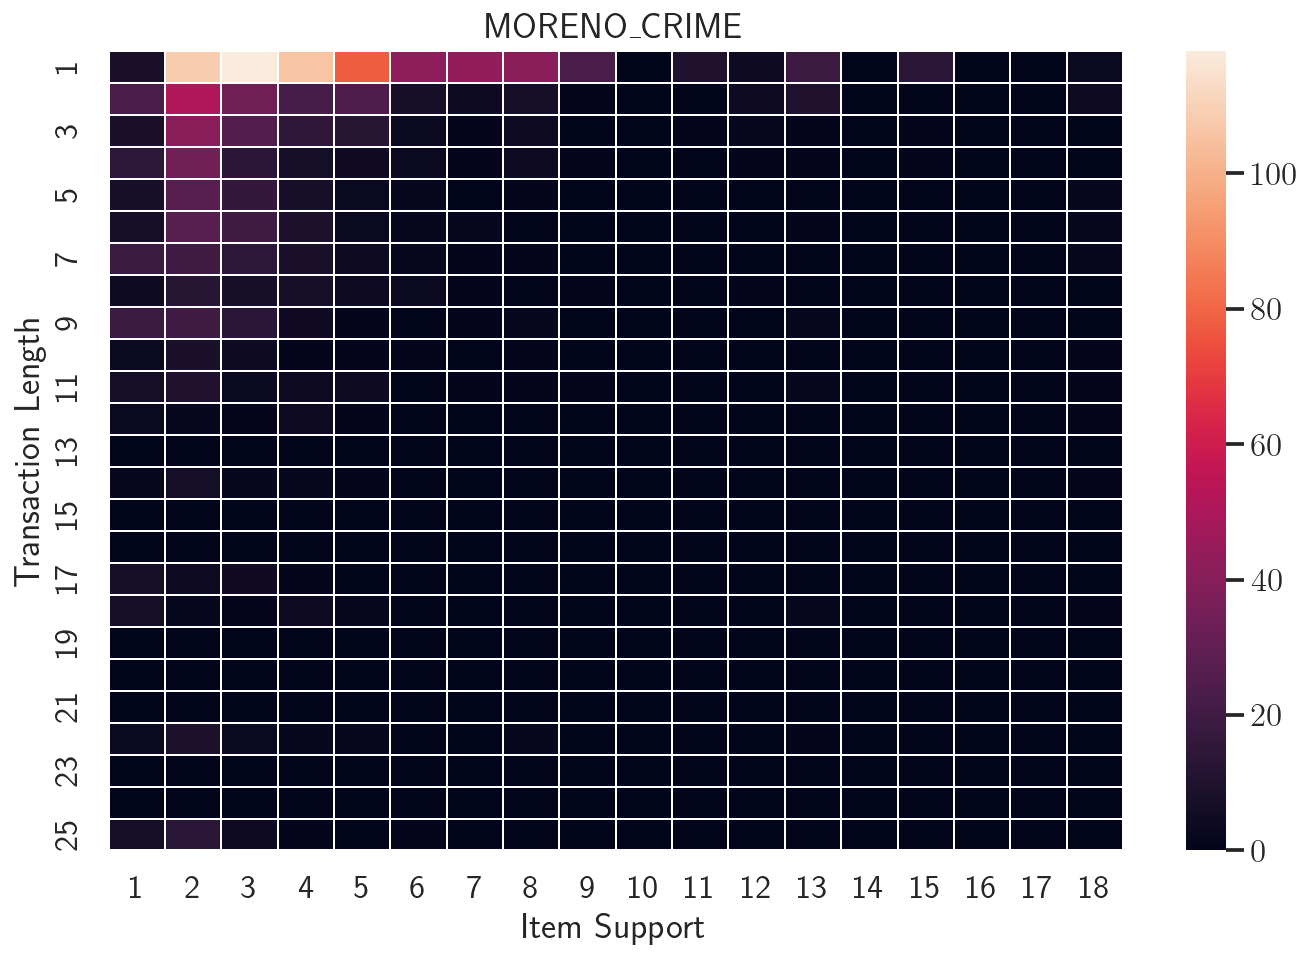

13 66


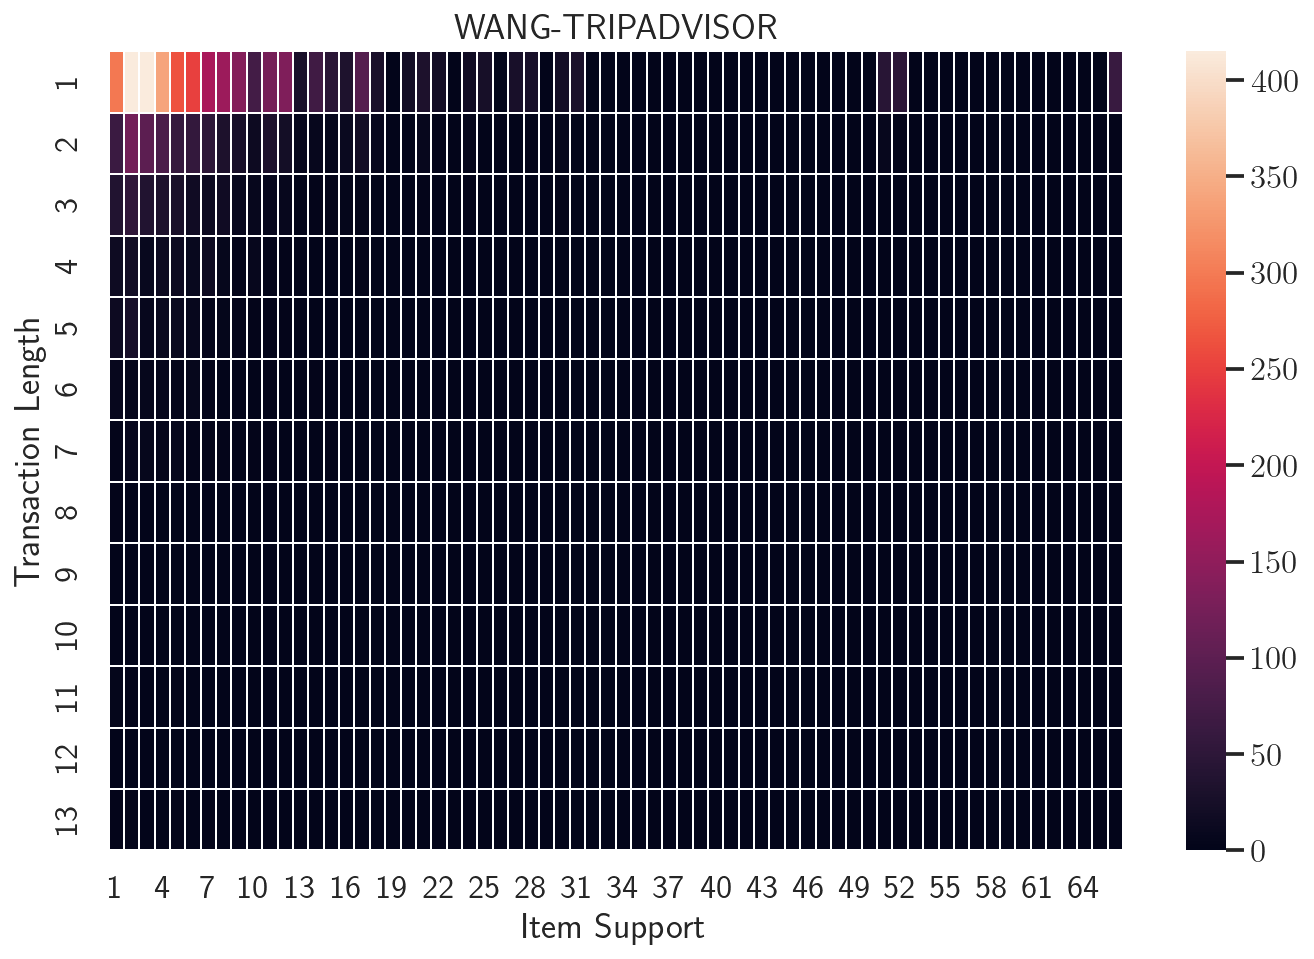

In [47]:
for dataset in datasets:
    BJDM, max_len = ds.compute_BJDM(data_dir, dataset)
    bjdm_df = pd.DataFrame(BJDM)
    fig, ax = plt.subplots(figsize=(10,7))
    # subset of cols
    ret_cols = []
    for c in bjdm_df.columns:
        if bjdm_df[c].sum() > 0:
            ret_cols.append(c)
    if len(ret_cols) > num_squares:
        cols = set()
        while len(cols) < num_squares:
            cols.add(ret_cols[random.randint(0, len(ret_cols)-1)])
        cols = sorted(list(cols))
        bjdm_df = bjdm_df[cols]
    # subset of rows
    ret_rows = []
    for r in bjdm_df.index:
        if bjdm_df.loc[r].sum() > 0:
            ret_rows.append(r)
    if len(ret_rows) > num_squares:
        rows = set()
        while len(rows) < num_squares:
            rows.add(ret_rows[random.randint(0,len(ret_rows)-1)])
        rows = sorted(list(rows))
        bjdm_df = bjdm_df.loc[rows]
    # all transactions have the same length
    if bjdm_df.shape[0] == 1:
        bjdm_df = bjdm_df[bjdm_df>0].T.dropna().T
    sns.heatmap(data=bjdm_df, linewidths=1, ax=ax)
    ax.set_ylabel('Transaction Length')
    ax.set_xlabel('Item Support')
    x_labels = []
    for l in ax.get_xticklabels():
        x_labels.append(str(int(l.get_text())+1))
    y_labels = []
    if bjdm_df.shape[0] == 1:
        y_labels.append(str(max_len))
    else:
        for l in ax.get_yticklabels():
            y_labels.append(str(int(l.get_text())+1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.set_title(dataset.upper())
    plt.tight_layout()
    plt.show()

### Item Support

In [13]:
result_dir = '../output/significantItemsets'

In [14]:
db_config = {'foodmart':'18319-2048-128-3.0E-4-0.05-32-0',
             'chess':'118252-2048-128-0.8-0.05-32-0',
             'mushrooms':'193568-1568-128-0.3-0.05-32-0',
             'BMS1':'299278-1568-128-0.001-0.05-32-0',
             'BMS2':'716556-1568-128-0.002-0.05-32-0'}
sampler = 'caterpillars.samplers.NaiveBJDMSampler'

In [15]:
dfs = []
for db,conf in db_config.items():
    try:
        file = f'{result_dir}/{db}-{sampler}-{conf}.json'
        dfs.append(sig.get_freq_itemsets(file, db))
    except Exception as e:
        print(e)
        pass

freq_it_df = pd.concat(dfs)

In [16]:
freq_it_df.groupby(by='DataSet').agg({'Support':'mean'})

,Support
DataSet,
BMS1,122.577549
BMS2,262.928591
chess,2688.501398
foodmart,5.599953
mushrooms,3098.767685


## Convergence

In [17]:
result_dir = '../output/convergence/'
# config
dbs = ['BMS1', 'BMS2', 'chess', 'foodmart', 'mushrooms']
freqs = {'BMS1':'0.001', 
         'BMS2':'0.002', 
         'chess':'0.8', 
         'foodmart':'3.0E-4', 
         'mushrooms':'0.3'}

In [18]:
dfs = []
for db in dbs:
    file = result_dir + f'{db}-6.0-{freqs[db]}-0.json'
    tmp_df = cs.get_convergence_df(file)
    tmp_df['DataSet'] = db
    dfs.append(tmp_df)

conv_df = pd.concat(dfs)

In [19]:
conv_df['Algorithm'] = conv_df['Algorithm'].apply(lambda x: sampler_names[x])

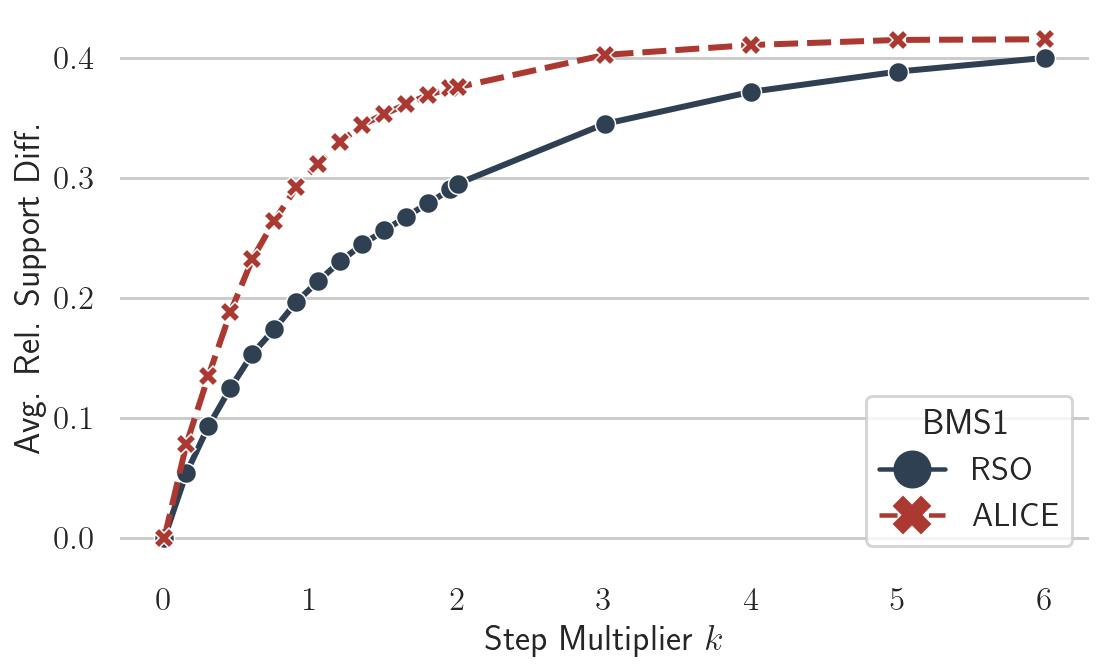

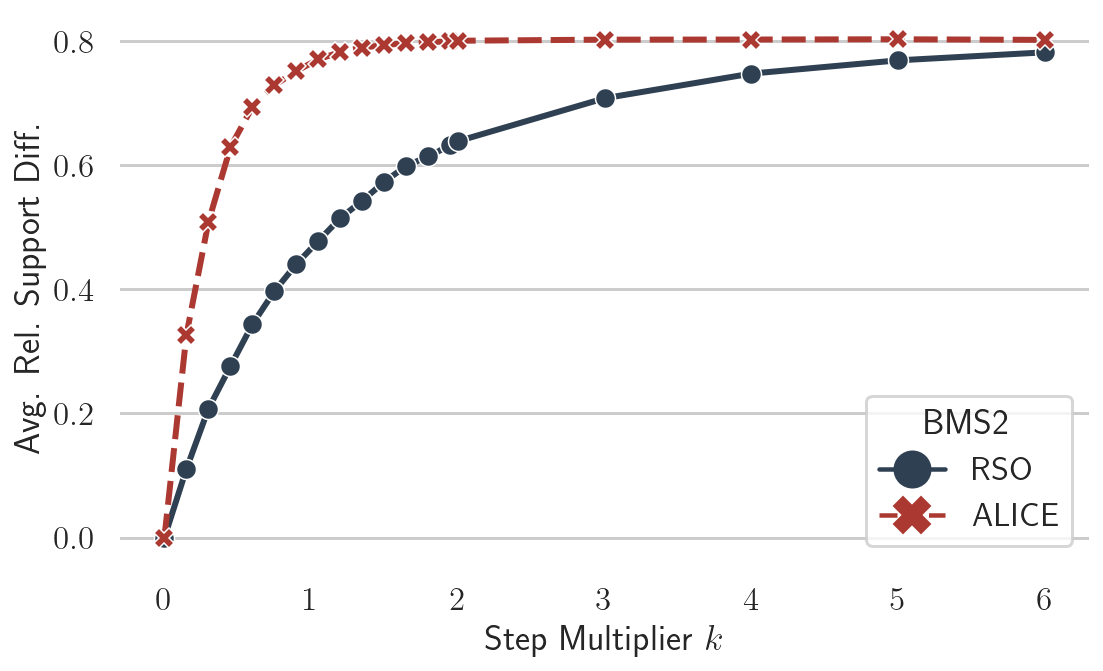

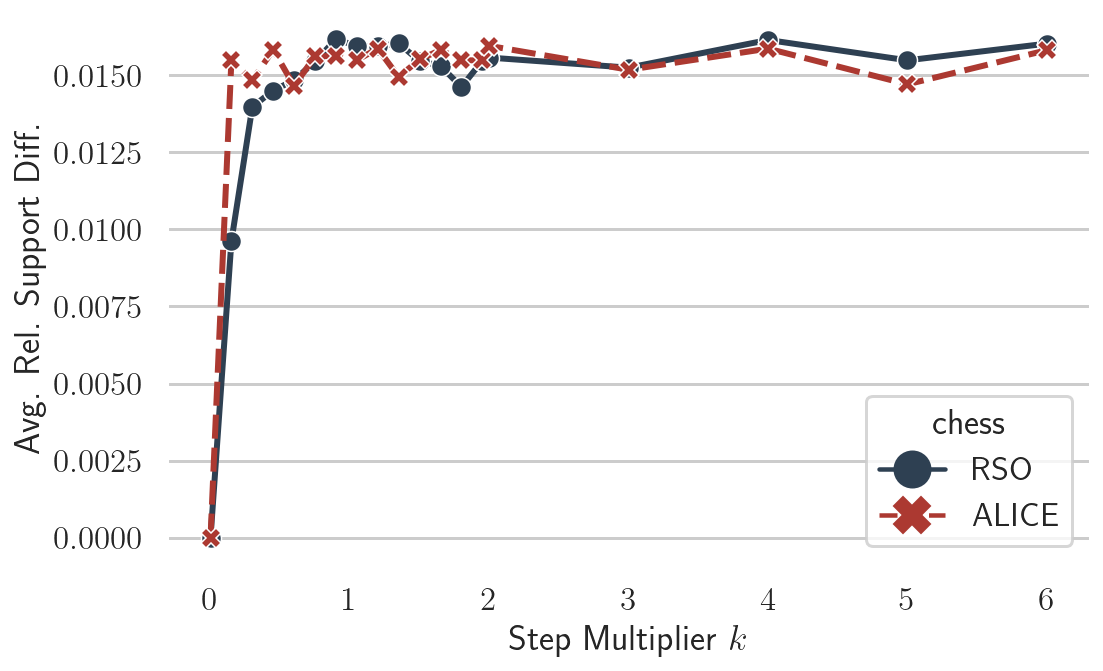

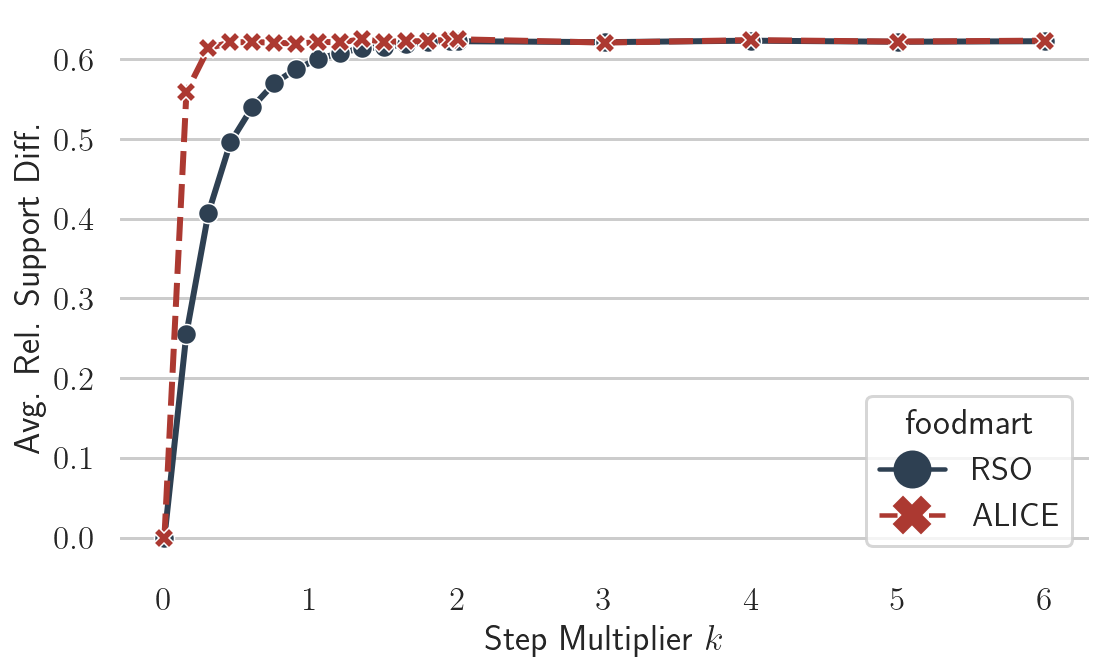

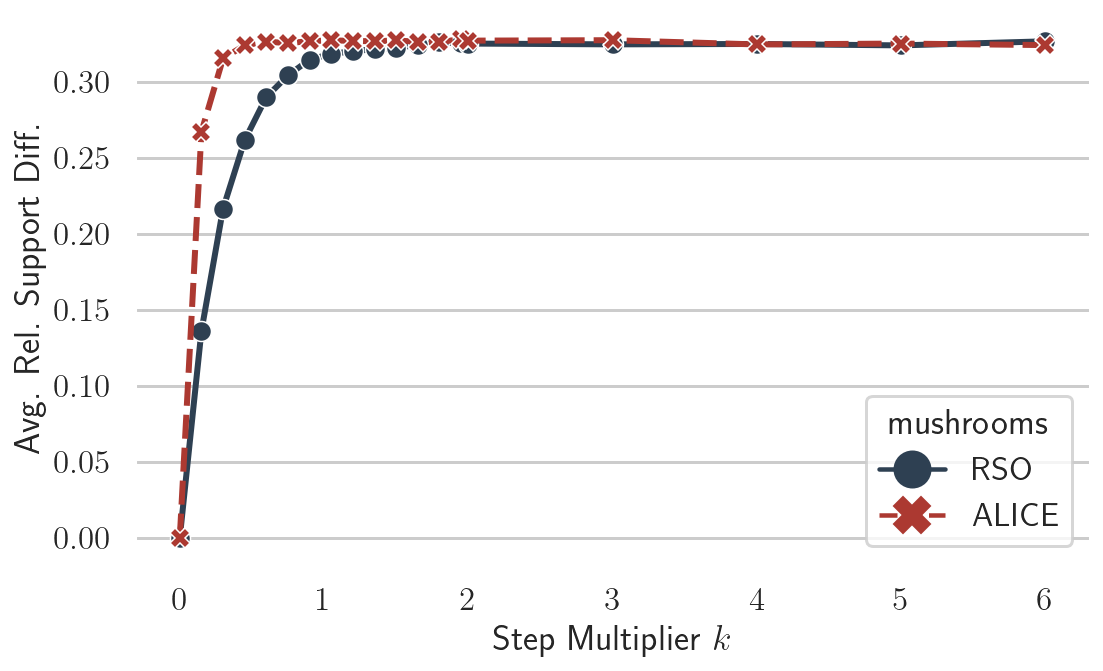

In [30]:
for dataset in datasets:
    data = conv_df[conv_df['DataSet']==dataset]
    num_colors = len(data['Algorithm'].unique())
    if not data.empty:
        fig, ax = plt.subplots(figsize=(8,5))
        sns.lineplot(data=data, x='Num Step Multiplier', palette=palette[:num_colors], 
                     style='Algorithm', markers=True, markersize=10, ax=ax,
                     linewidth=3, y='Avg. Rel. Support Diff.', hue='Algorithm')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xlabel(r'Step Multiplier $k$')
        ax.legend(title=dataset)
        plt.tight_layout()
        plt.savefig(fig_dir+f'convergence_{dataset}.pdf')

Single plot with 3 datasets

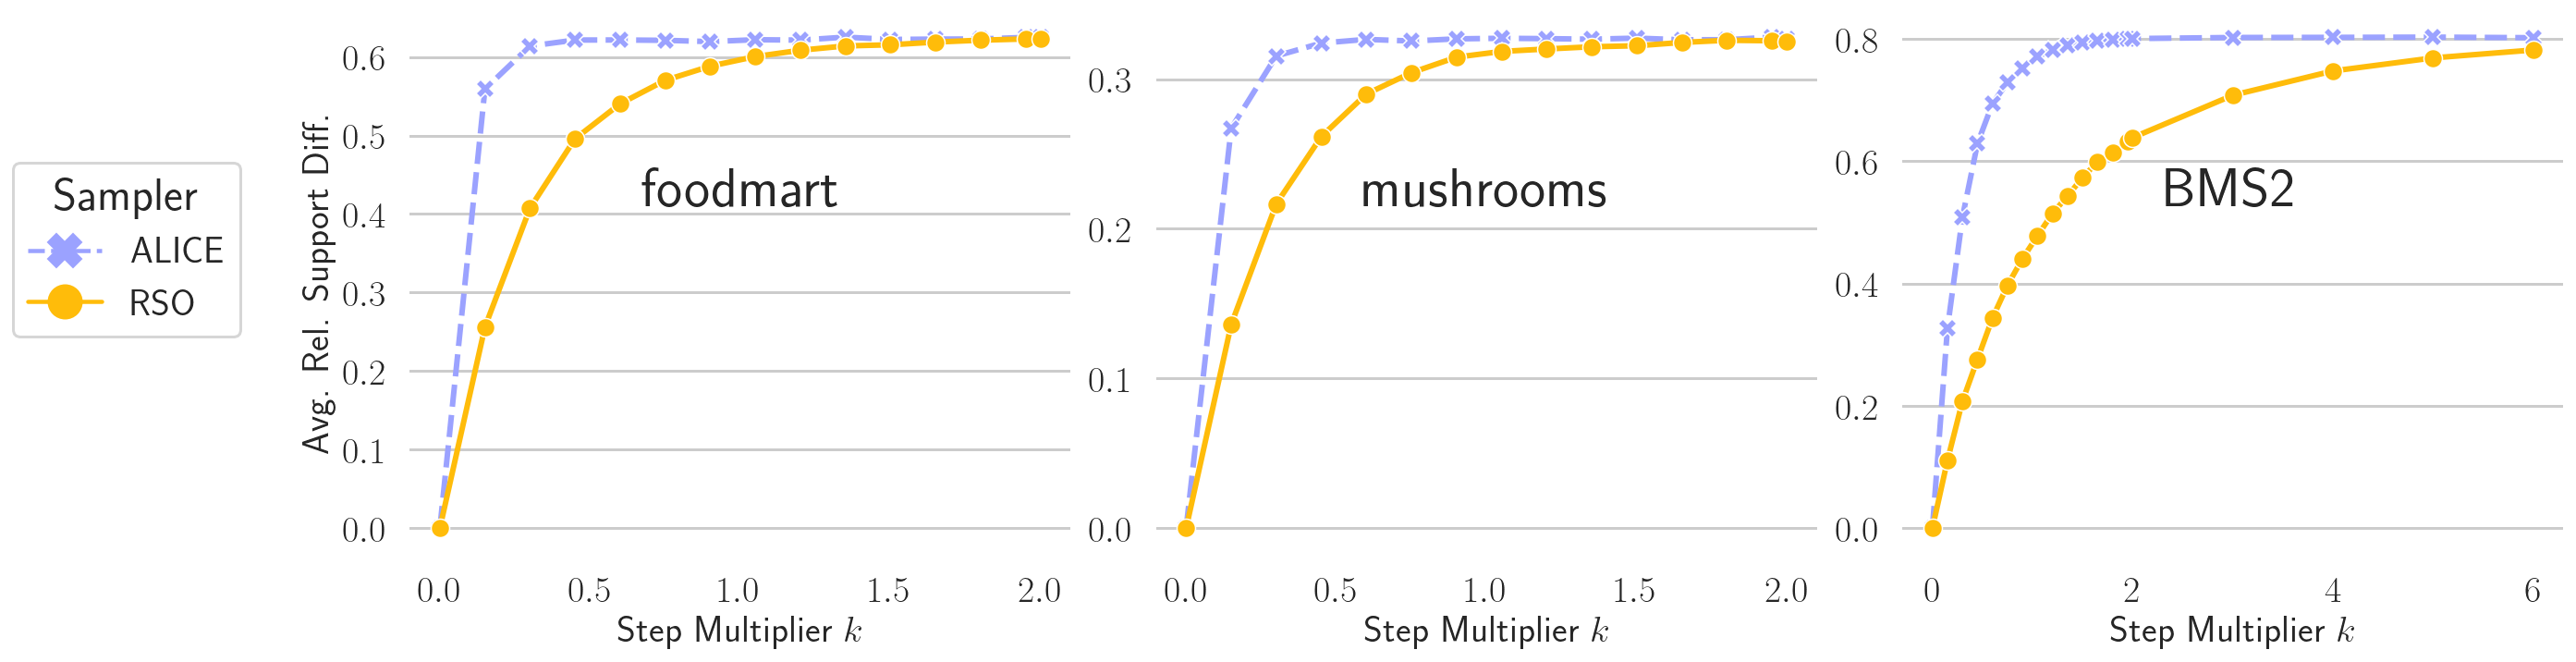

In [59]:
fig, ax = plt.subplots(1,3, figsize=(19,5))

for idx, dataset in enumerate(['foodmart', 'mushrooms', 'BMS2']):
    data = conv_df[conv_df['DataSet']==dataset].copy()
    num_colors = len(data['Algorithm'].unique())
    
    if dataset in ['foodmart', 'mushrooms']:
        data = data[data['Num Step Multiplier']<=2]
    sns.lineplot(data=data, x='Num Step Multiplier', palette=palette[:num_colors], 
                 style='Algorithm', markers=True, markersize=10, ax=ax[idx],
                 linewidth=3, y='Avg. Rel. Support Diff.', hue='Algorithm',
                 hue_order=['ALICE', 'RSO'])
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['left'].set_visible(False)
    ax[idx].spines['bottom'].set_visible(False)
    ax[idx].set_xlabel(r'Step Multiplier $k$')
    if idx != 0:
        ax[idx].set_ylabel('')
    # legend
    leg = ax[idx].legend()
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    ax[idx].legend(loc=(-0.6,0.4), fontsize=20, title='Sampler', title_fontsize=25)
    if idx != 0:
        ax[idx].legend().remove()  
    ax[idx].set_title(dataset, fontsize=30, pad=-105)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig(fig_dir+'convergence_all.pdf', bbox_inches='tight')

Time to Convergence

In [20]:
conv_time_df = conv_df.merge(stats_df[['DataSet', 'Sum Transaction Lengths']], on='DataSet')

In [21]:
conv_time_df['Time'] = conv_time_df['Setup'] + conv_time_df['Total'] 

In [22]:
conv_time_df['Time (s)'] = conv_time_df['Time'] / 1000

BMS1


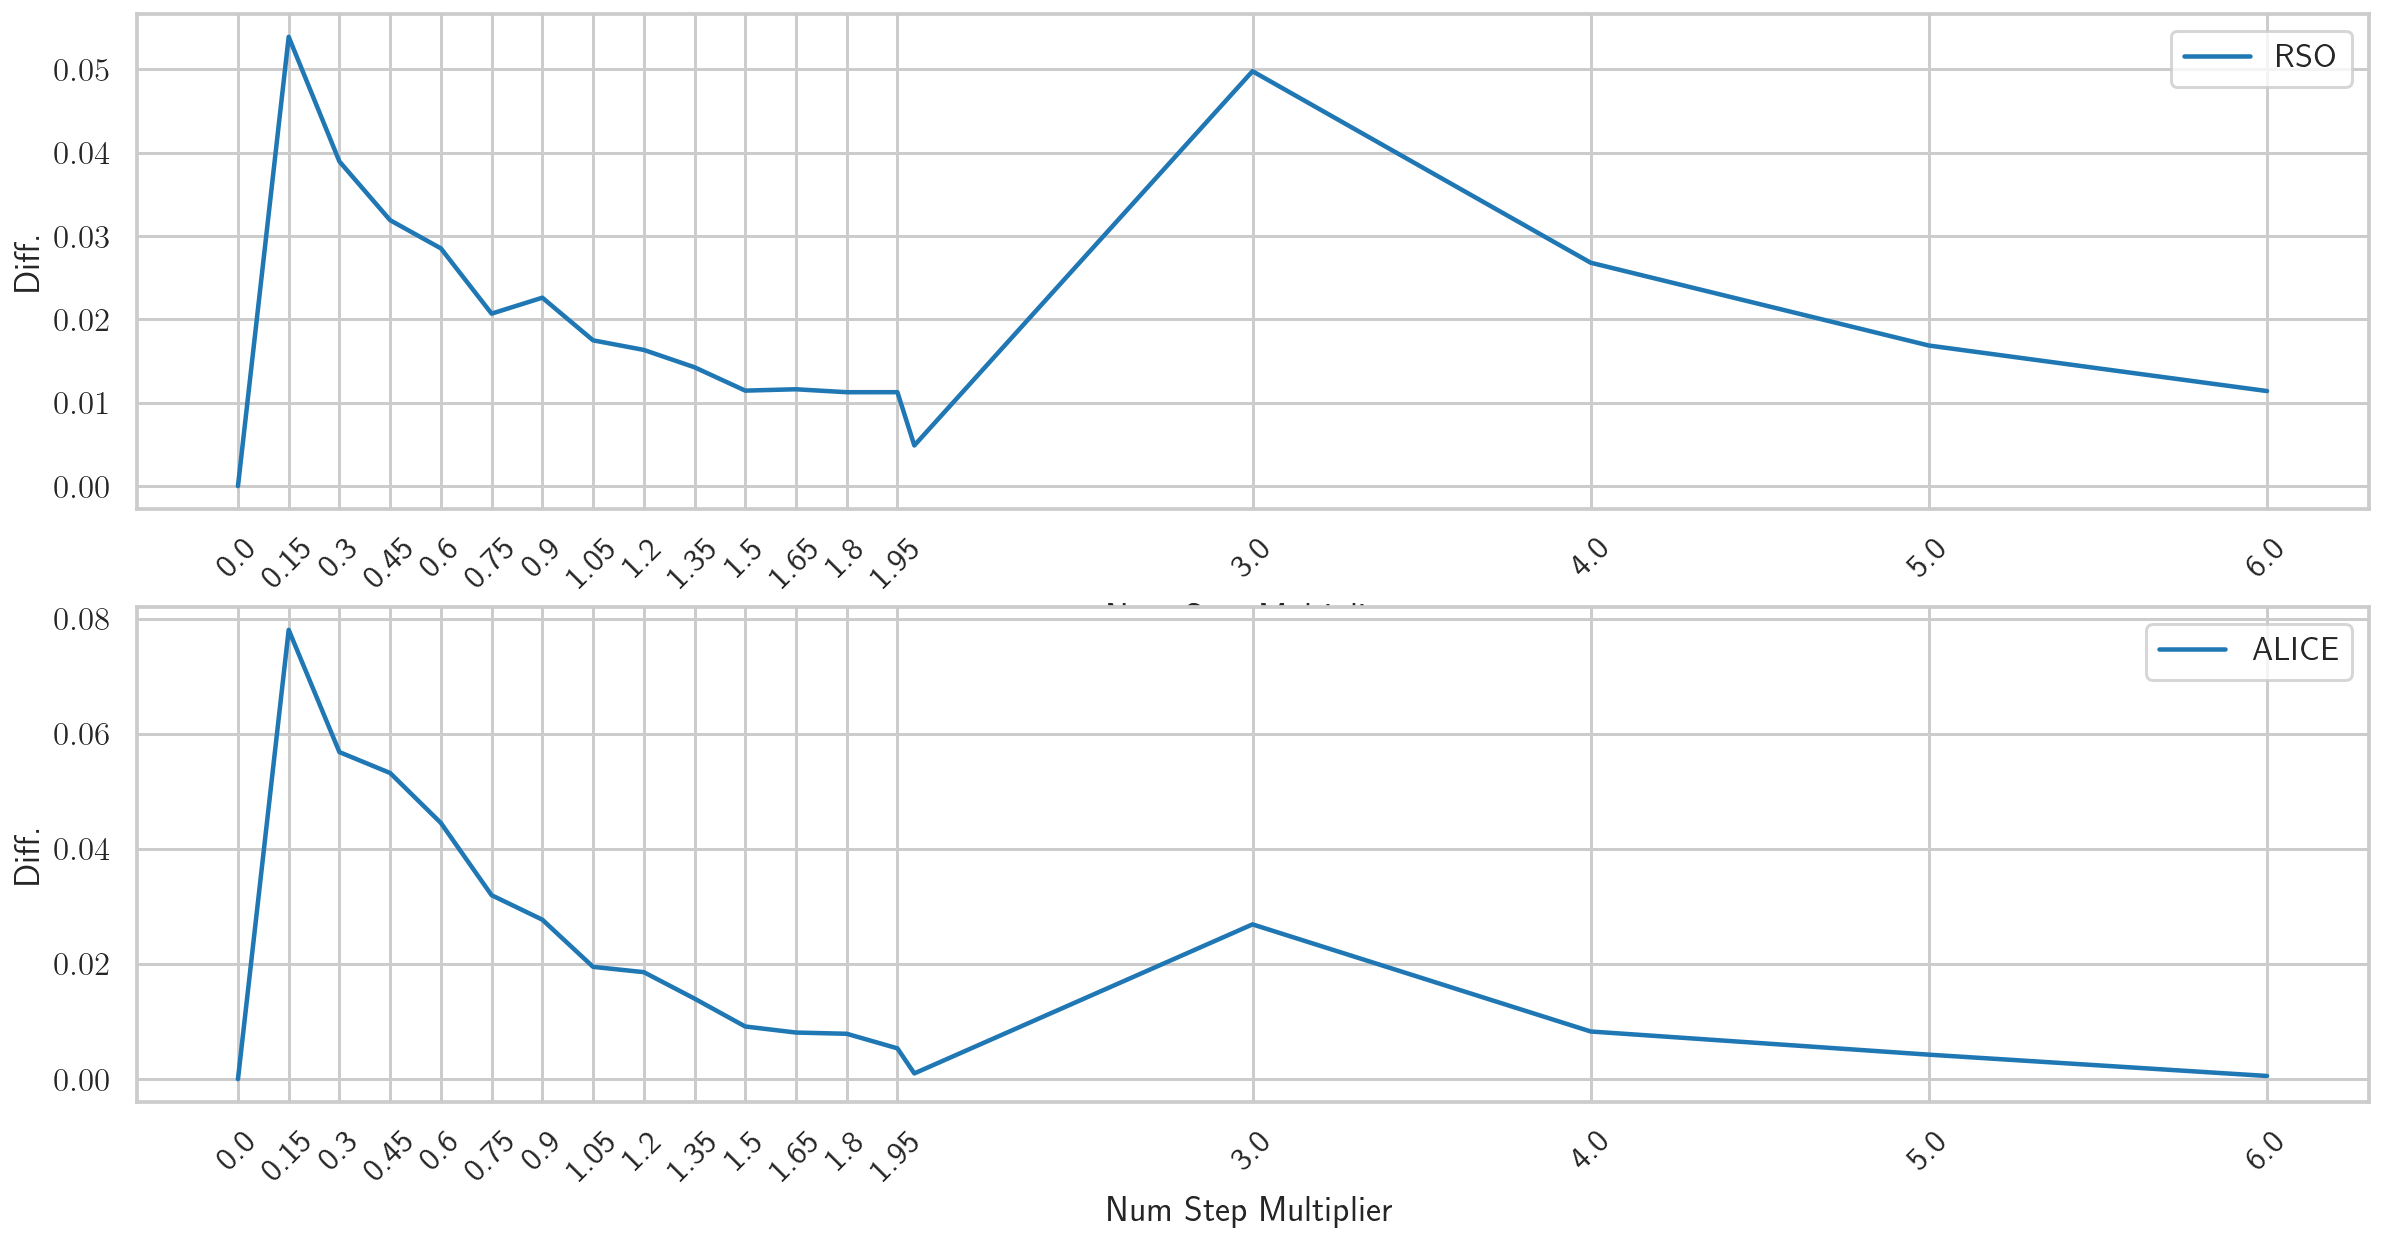

BMS2


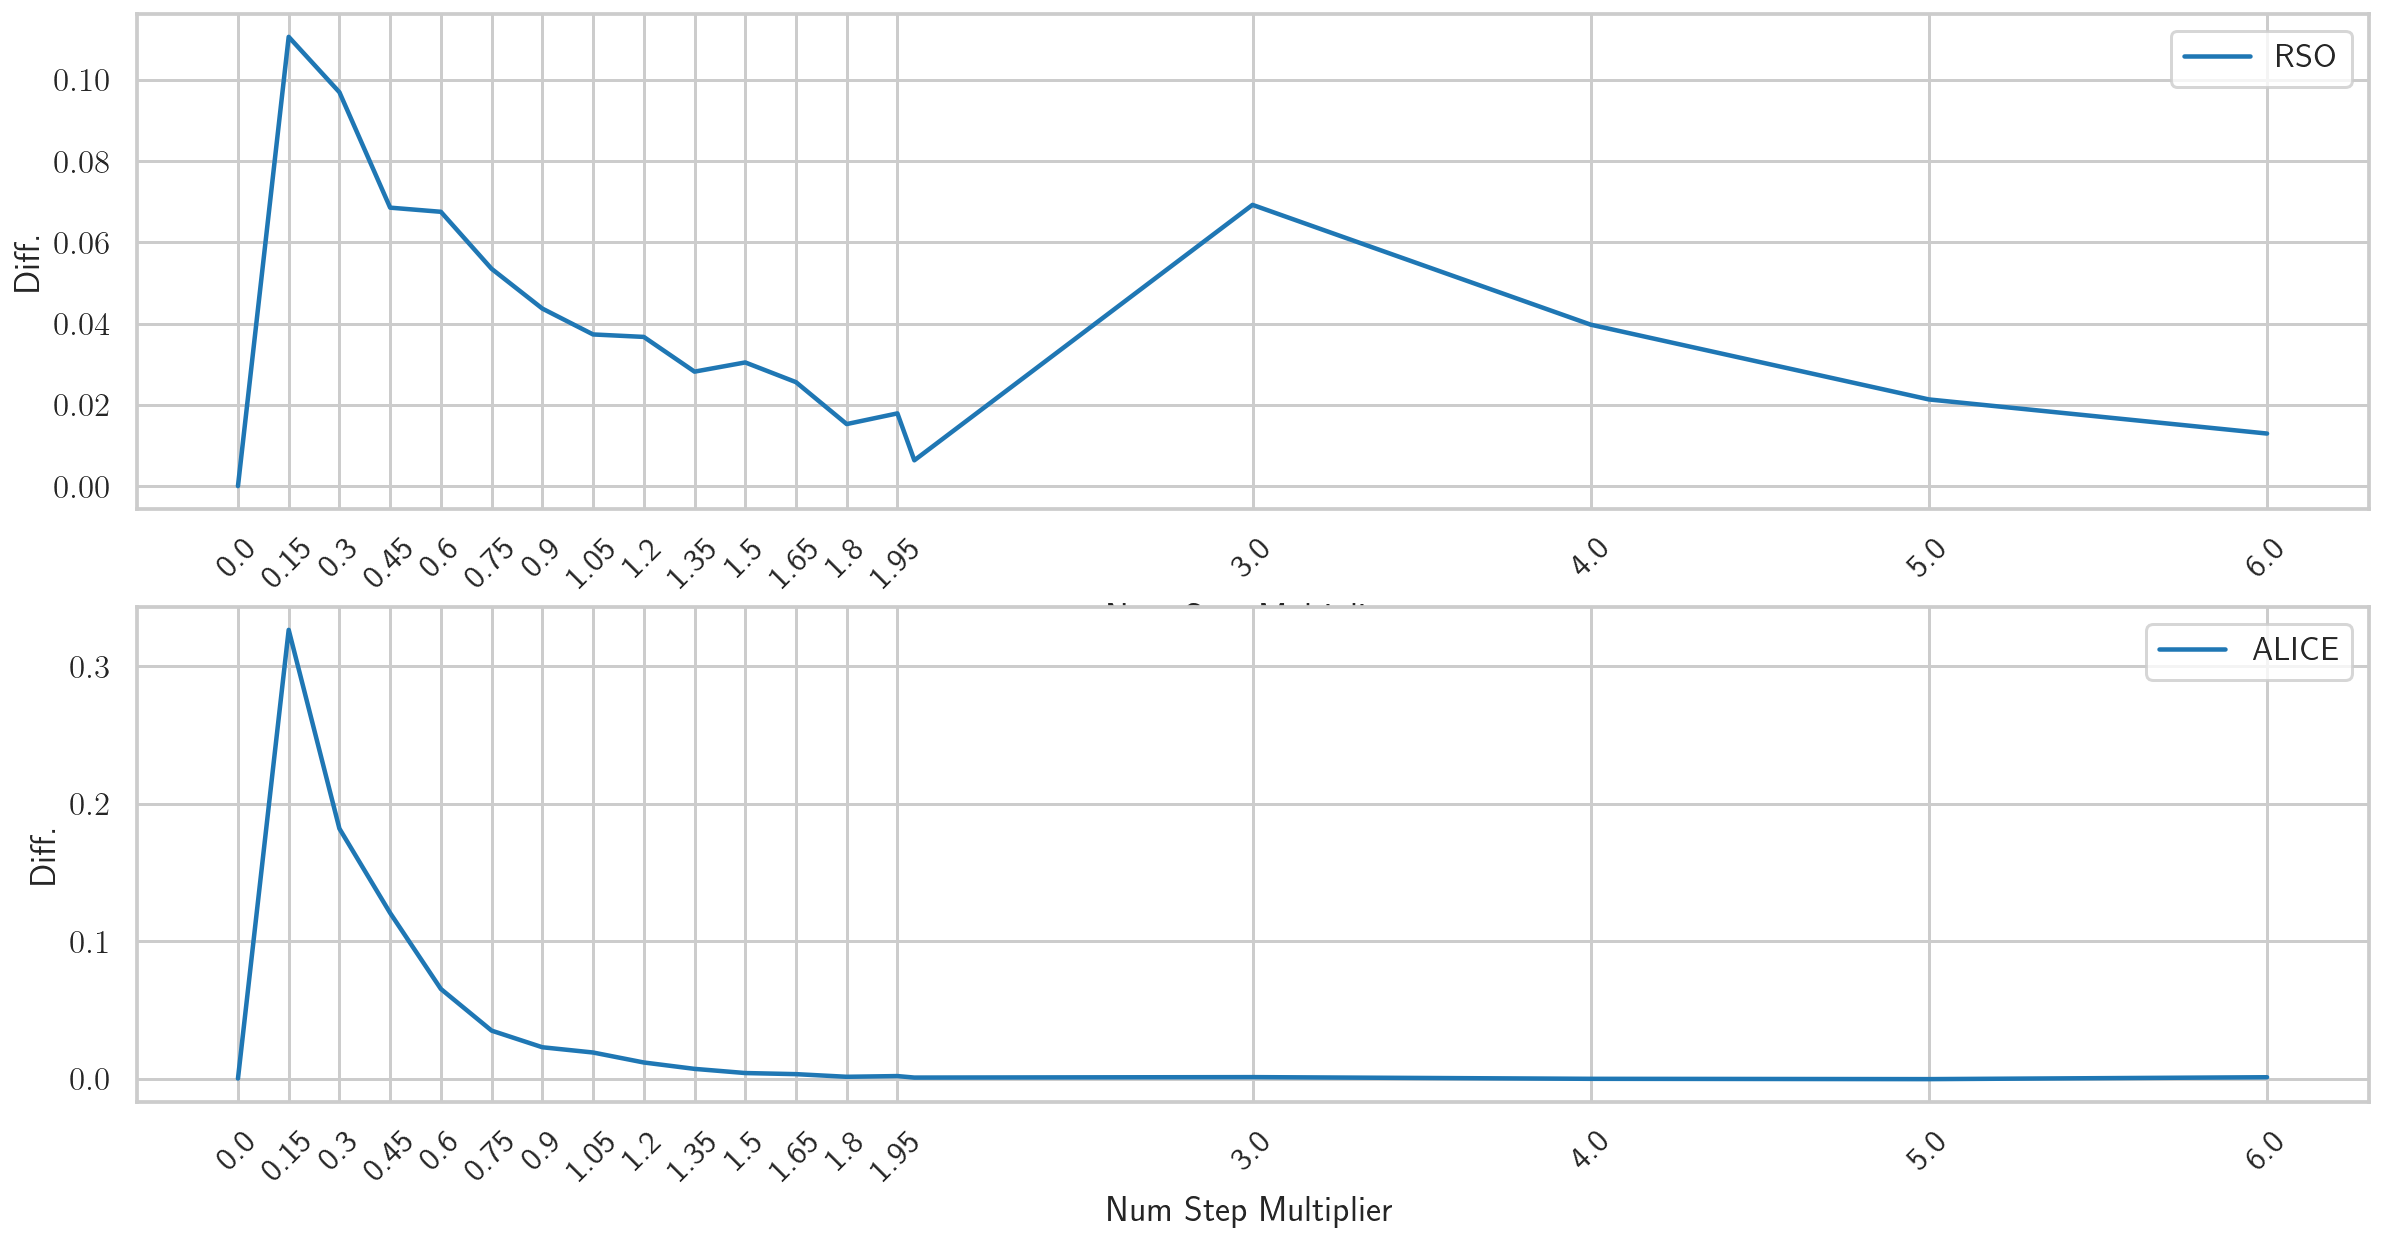

CHESS


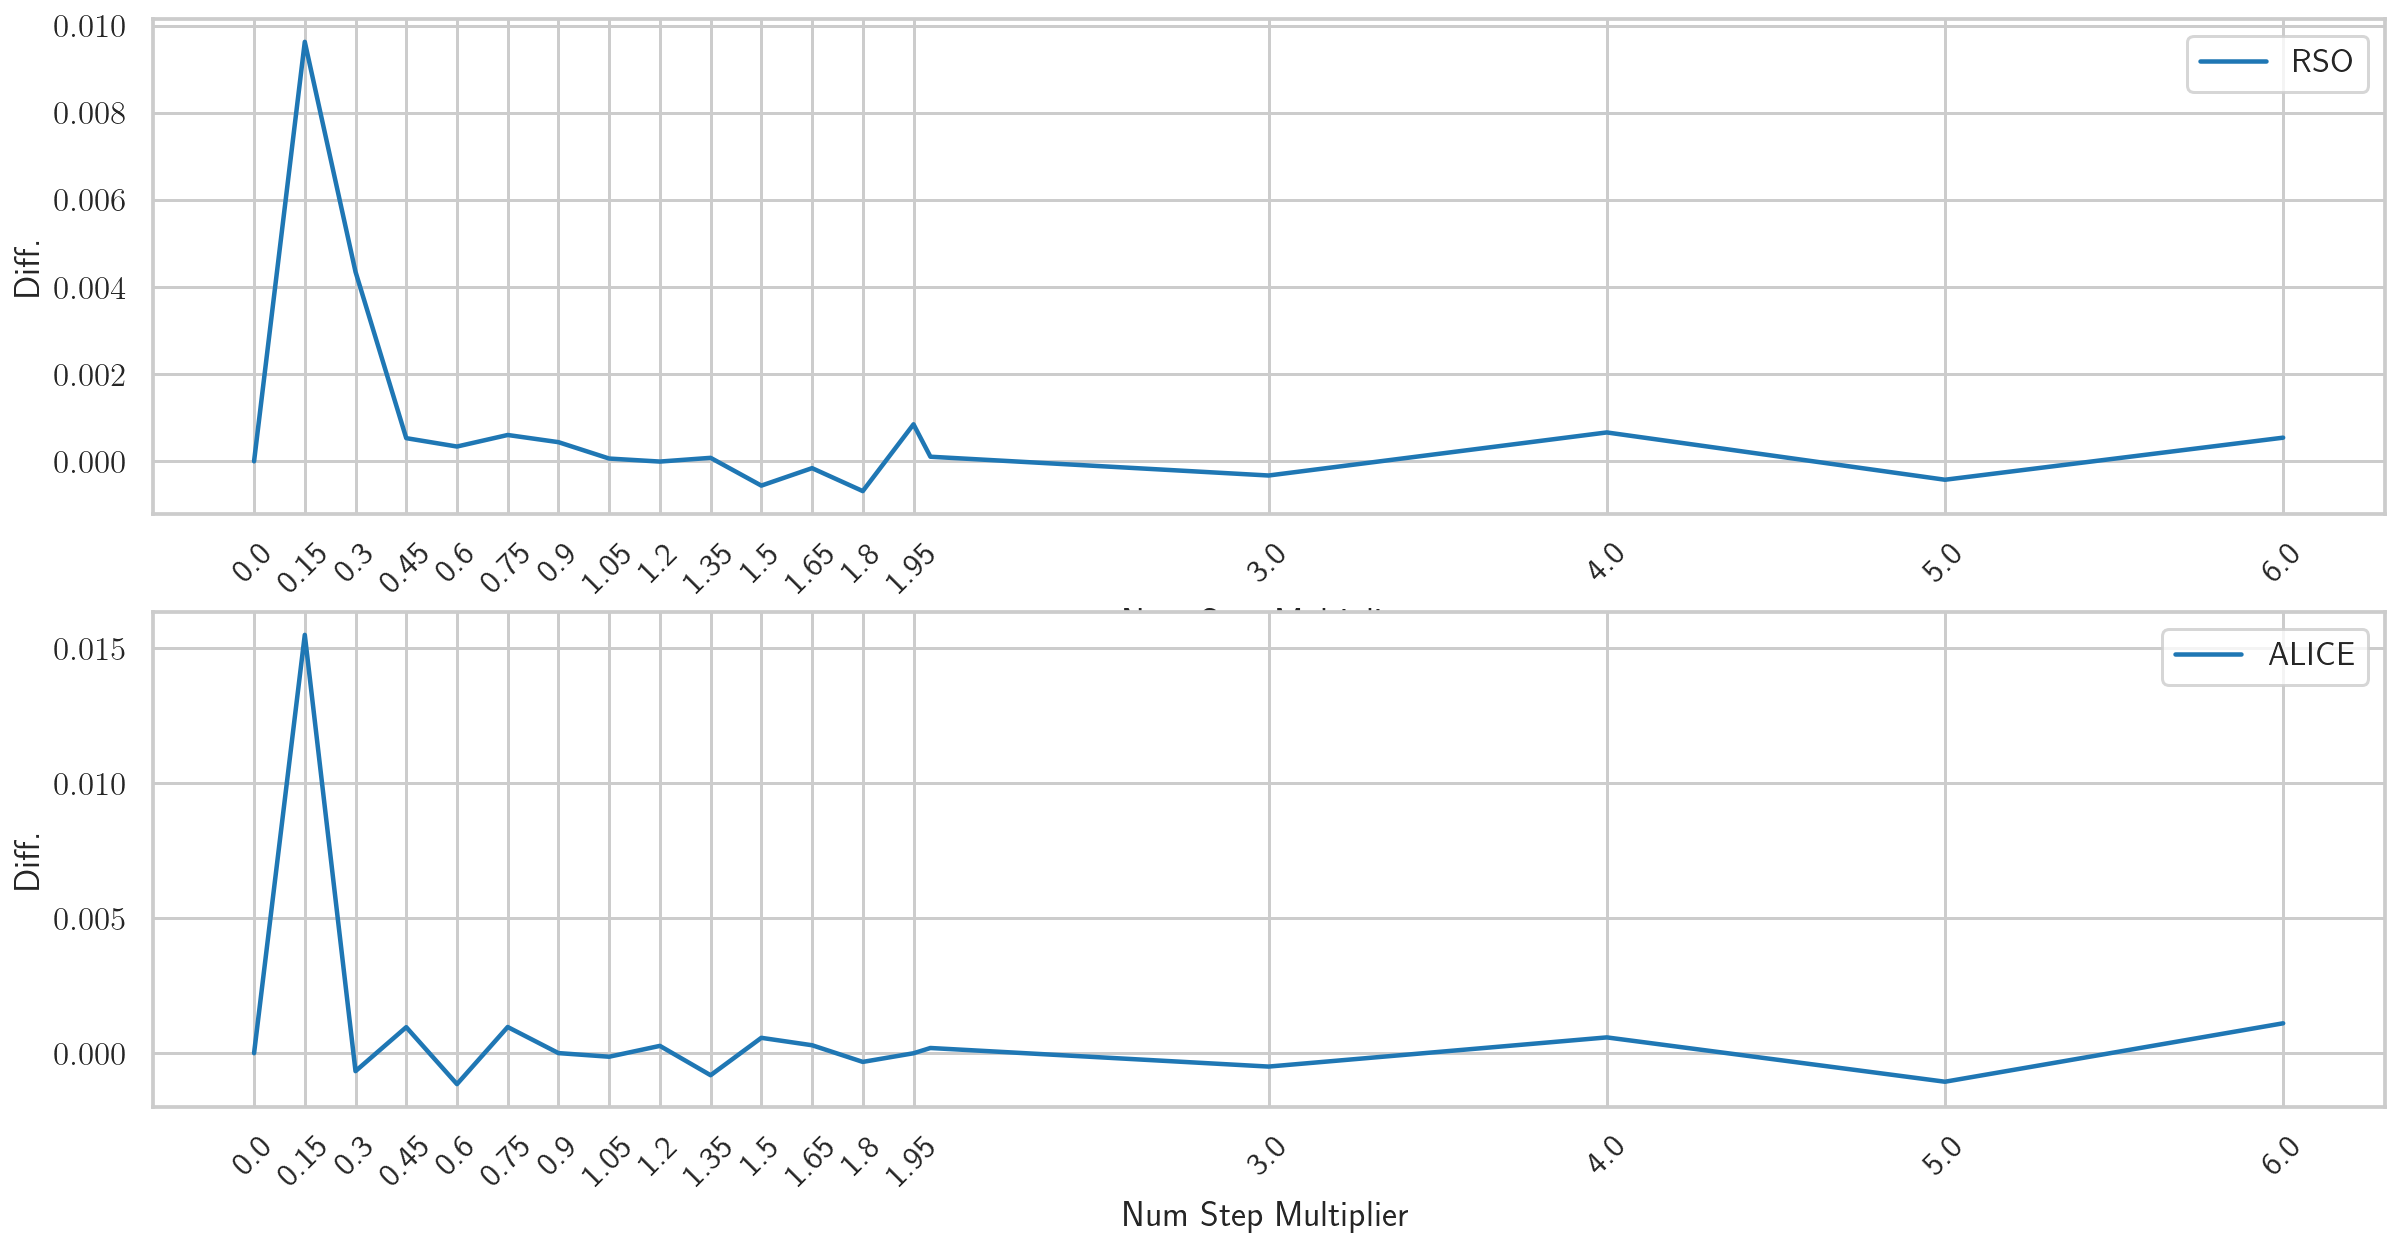

FOODMART


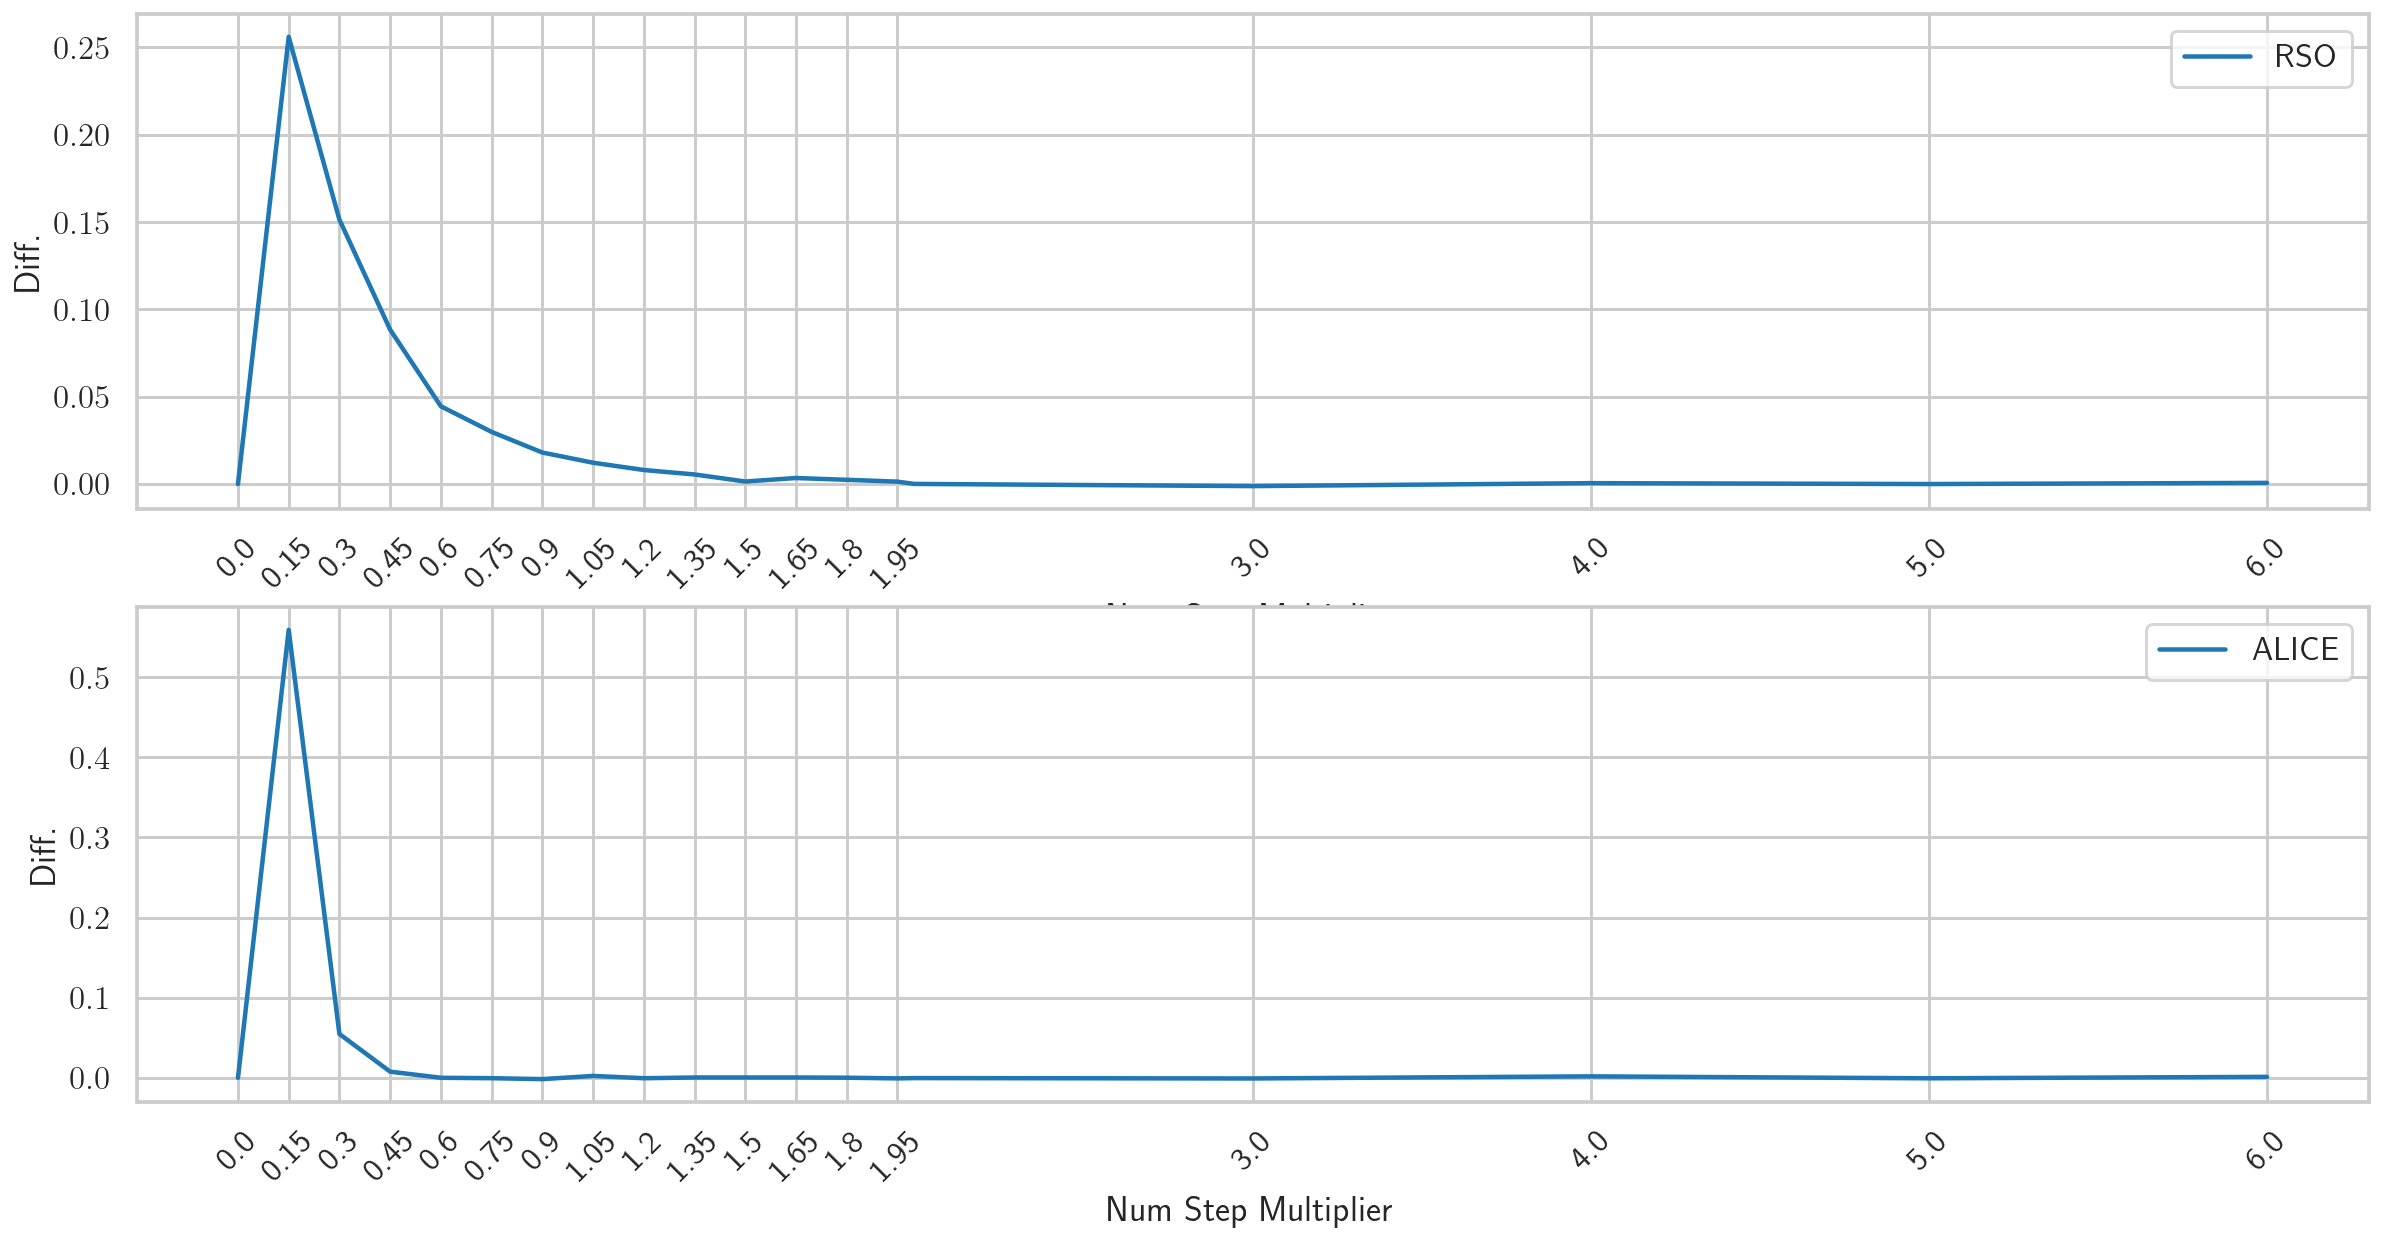

MUSHROOMS


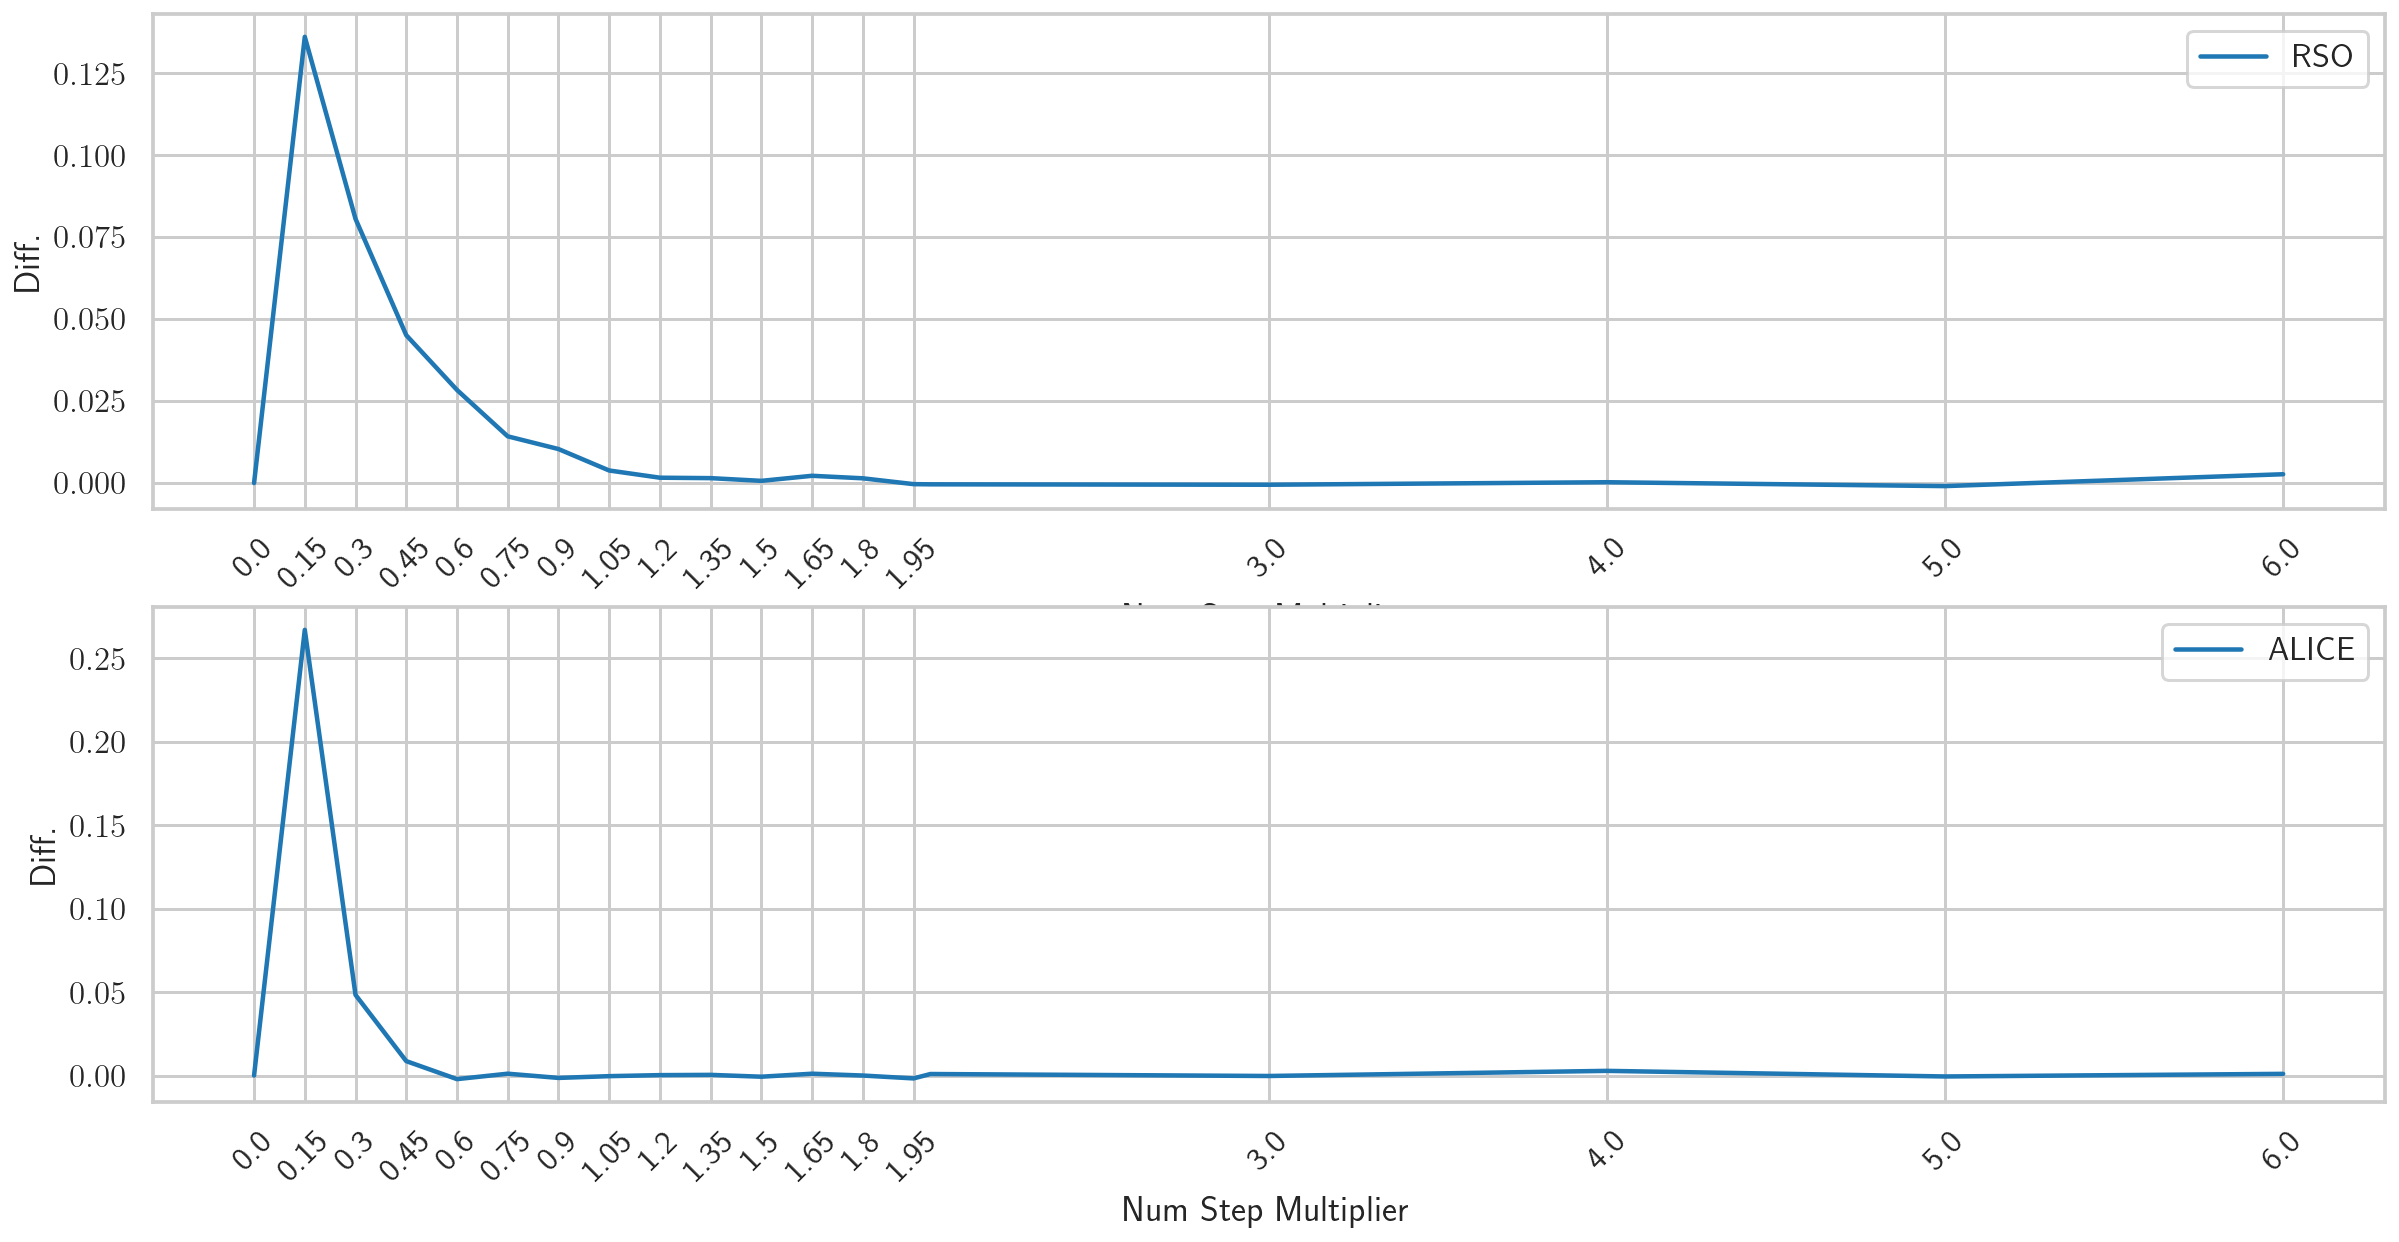

In [36]:
for db in conv_time_df['DataSet'].unique():
    print(db.upper())
    fig, ax = plt.subplots(2, 1, figsize=(20,10))
    conv_diff_df = pd.DataFrame()
    for idx, sampler in enumerate(conv_time_df['Algorithm'].unique()):
        tmp = conv_time_df[(conv_time_df['Algorithm']==sampler) &
                           (conv_time_df['DataSet']==db)].copy()
        maxARSD = tmp.loc[tmp['Num Step Multiplier']==6.0, 'Avg. Rel. Support Diff.'].values[0]
        tmp['Diff.'] = (tmp['Avg. Rel. Support Diff.'] - maxARSD).apply(abs)
        tmp['Diff.'] = (tmp['Diff.'].shift(1) - tmp['Diff.']).fillna(0)
        
        tmp2 = tmp[['Num Step Multiplier', 'Avg. Rel. Support Diff.', 'Diff.']].copy()
        tmp2.rename(columns={'Diff.':sampler,
                             'Avg. Rel. Support Diff.':f'ARSD_{sampler}'}, inplace=True)
        if conv_diff_df.empty:
            conv_diff_df = tmp2
        else:
            conv_diff_df = conv_diff_df.merge(tmp2)
        
        sns.lineplot(data=tmp, x='Num Step Multiplier', y='Diff.', ax=ax[idx], hue='Algorithm')
        ax[idx].legend()
        ticks = list(tmp['Num Step Multiplier'].values)
        ticks.remove(2.0)
        labels = [str(round(x,3)) for x in tmp['Num Step Multiplier'].values]
        labels.remove('2.0')
        ax[idx].set_xticks(ticks)
        ax[idx].set_xticklabels(labels, rotation=45, ha='center')
        ax[idx].grid(which='both', axis='x')
#     display(conv_diff_df.set_index('Num Step Multiplier'))
    plt.show()

In [41]:
## mushrooms
# ALICE = 0.6 (105.191), RSO = 1.2 (2.943)
## foodmart
# ALICE = 0.45 (0.134), RSO = 1.5 (0.069)
## BMS2
# ALICE = 1.8 (15.8), RSO = 6 (10.05)

## Scalability

In [23]:
result_dir = '../output/scalability/'
# config
dbs = ['synthetic-5', 'synthetic-10', 
       'synthetic-15', 'synthetic-20']
real_dbs = ['chess', 'foodmart', 'mushrooms', 'BMS1', 'BMS2']

In [24]:
dfs = []
for db in dbs:
    file_name = f'{db}-25-0.1-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_scalability_df(file, file_name)
    tmp_df['DataSet'] = db
    dfs.append(tmp_df)
for db in real_dbs:
    file_name = f'{db}-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_scalability_df(file, file_name)
    tmp_df['DataSet'] = db
    dfs.append(tmp_df)
    
results_df = pd.concat(dfs)

In [25]:
results_df['Algorithm'] = results_df['Algorithm'].apply(lambda x: sampler_names[x])

### Synthetic Datasets

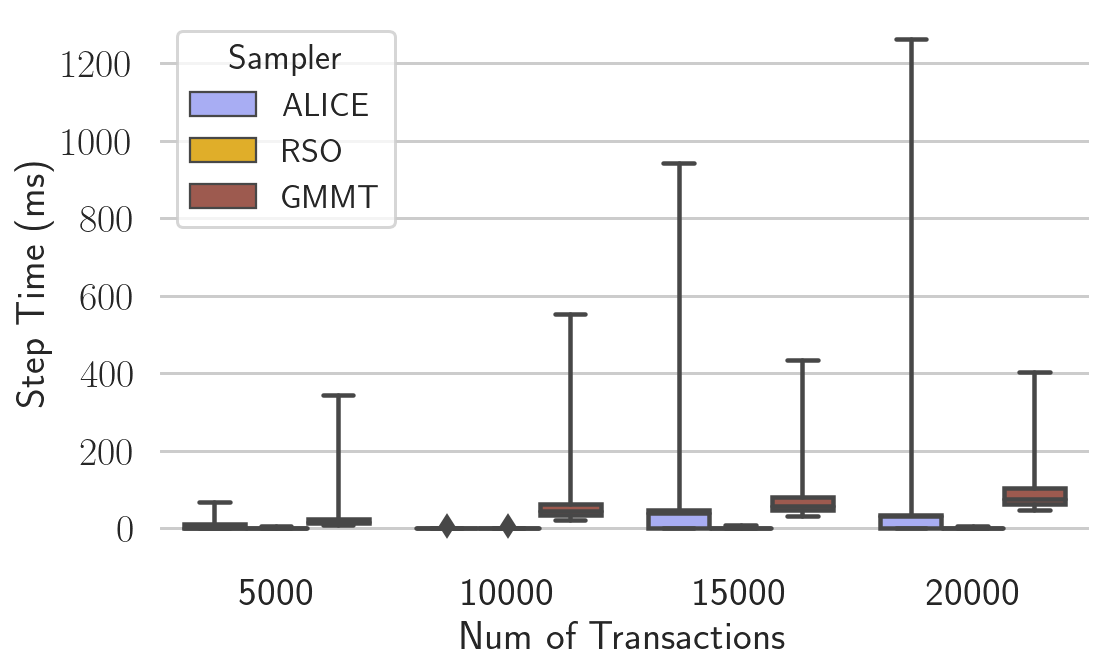

In [60]:
fig, ax = plt.subplots(figsize=(8,5))

data = results_df[results_df['DataSet'].isin(dbs)]
sns.set_theme(style='whitegrid', context='talk')
sns.boxplot(data=data, x='Number of transactions', whis=100,
            palette=palette, fliersize=8, y='Step time (ms)', 
            hue='Algorithm', hue_order=['ALICE', 'RSO', 'GMMT'], ax=ax)
# ax.set_ylim(top=100, bottom=0)
ax.set_xlabel('Num of Transactions')
ax.set_ylabel('Step Time (ms)')
ax.legend(title='Sampler')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_dir+'scalability.pdf')

### Real Datasets

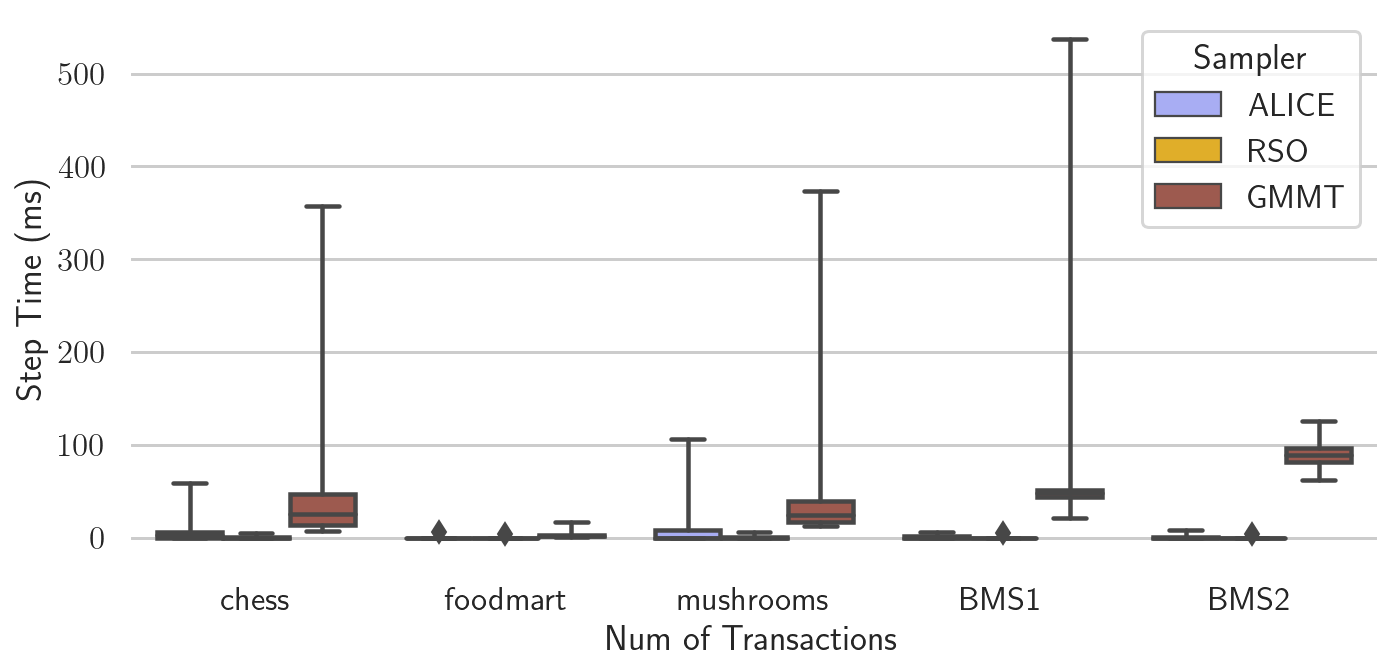

In [61]:
fig, ax = plt.subplots(figsize=(10,5))

data = results_df[results_df['DataSet'].isin(real_dbs)]
sns.boxplot(data=data, x='DataSet', whis=100,
            palette=palette, fliersize=8, y='Step time (ms)', 
            hue='Algorithm', hue_order=['ALICE', 'RSO', 'GMMT'], ax=ax)
# ax.set_ylim(top=100, bottom=0)
ax.set_xlabel('Num of Transactions')
ax.set_ylabel('Step Time (ms)')
ax.legend(title='Sampler')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_dir+'scalability_real.pdf')

#### Step Time

In [26]:
dfs = []
for db in real_dbs:
    file_name = f'{db}-10000-0.json'
    file = result_dir + file_name
    tmp_df = ss.get_step_times_df(file)
    tmp_df['DataSet'] = db
    dfs.append(tmp_df)
swap_df = pd.concat(dfs)

In [27]:
swap_df.columns = ['Algorithm', 'min', 'C10', 'Q1', 'med.', 'Q3', 'C90', 'max', 'Dataset']

In [28]:
swap_df['Algorithm'] = swap_df['Algorithm'].apply(lambda x: sampler_names[x])

In [29]:
sorted_df = swap_df.sort_values(by=['Dataset', 'Algorithm'])

In [67]:
print(sorted_df.to_latex(index=False, column_format='llrrrrr',
                        caption='Step time (ms): minimum, 1st quartile, median, 3rd quartile, and maximum over 10K steps.',
                        label='tbl:steptime', position='!ht'))

\begin{table}[!ht]
\centering
\caption{Step time (ms): minimum, 1st quartile, median, 3rd quartile, and maximum over 10K steps.}
\label{tbl:steptime}
\begin{tabular}{llrrrrr}
\toprule
Algorithm &  min &  C10 &  Q1 &  med. &  Q3 &  C90 &  max &   Dataset \\
\midrule
    ALICE &    0 &    0 &   0 &     0 &   1 &    2 &    6 &      BMS1 \\
     GMMT &   21 &   43 &  45 &    48 &  50 &   52 &  537 &      BMS1 \\
      RSO &    0 &    0 &   0 &     0 &   0 &    0 &    5 &      BMS1 \\
    ALICE &    0 &    0 &   0 &     0 &   1 &    1 &    8 &      BMS2 \\
     GMMT &   62 &   79 &  84 &    89 &  94 &   98 &  126 &      BMS2 \\
      RSO &    0 &    0 &   0 &     0 &   0 &    0 &    4 &      BMS2 \\
    ALICE &    0 &    0 &   0 &     3 &   4 &    7 &   59 &     chess \\
     GMMT &    7 &   12 &  16 &    25 &  38 &   56 &  357 &     chess \\
      RSO &    0 &    0 &   0 &     0 &   1 &    1 &    5 &     chess \\
    ALICE &    0 &    0 &   0 &     0 &   0 &    0 &    6 &  foodmart \\
    

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_4340/3193412779.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sorted_df.to_latex(index=False, column_format='llrrrrr',


## Num Frequent Itemsets

In [30]:
result_dir = '../output/numFreqItemsets'

In [31]:
db_config = {'foodmart':'18319-2176-3.0E-4-32-0',
             'chess':'118252-2176-0.8-32-0',
             'mushrooms':'193568-2176-0.3-32-0',
             'BMS1':'299278-2176-0.001-32-0',
             'BMS2':'716556-2048-0.002-32-0'
            }

In [32]:
dfs = []
for db,conf in db_config.items():
    try:
        filepath = f'{result_dir}/{db}-{conf}.json'
        df = ns.get_num_freq_itemsets_stats(filepath, db.upper())
        df['DataSet'] = db
        dfs.append(df)
    except Exception as e:
        pass
numfreq_df = pd.concat(dfs)

In [33]:
numfreq_df['Algorithm'] = numfreq_df['Algorithm'].apply(lambda x: sampler_names.get(x, x))

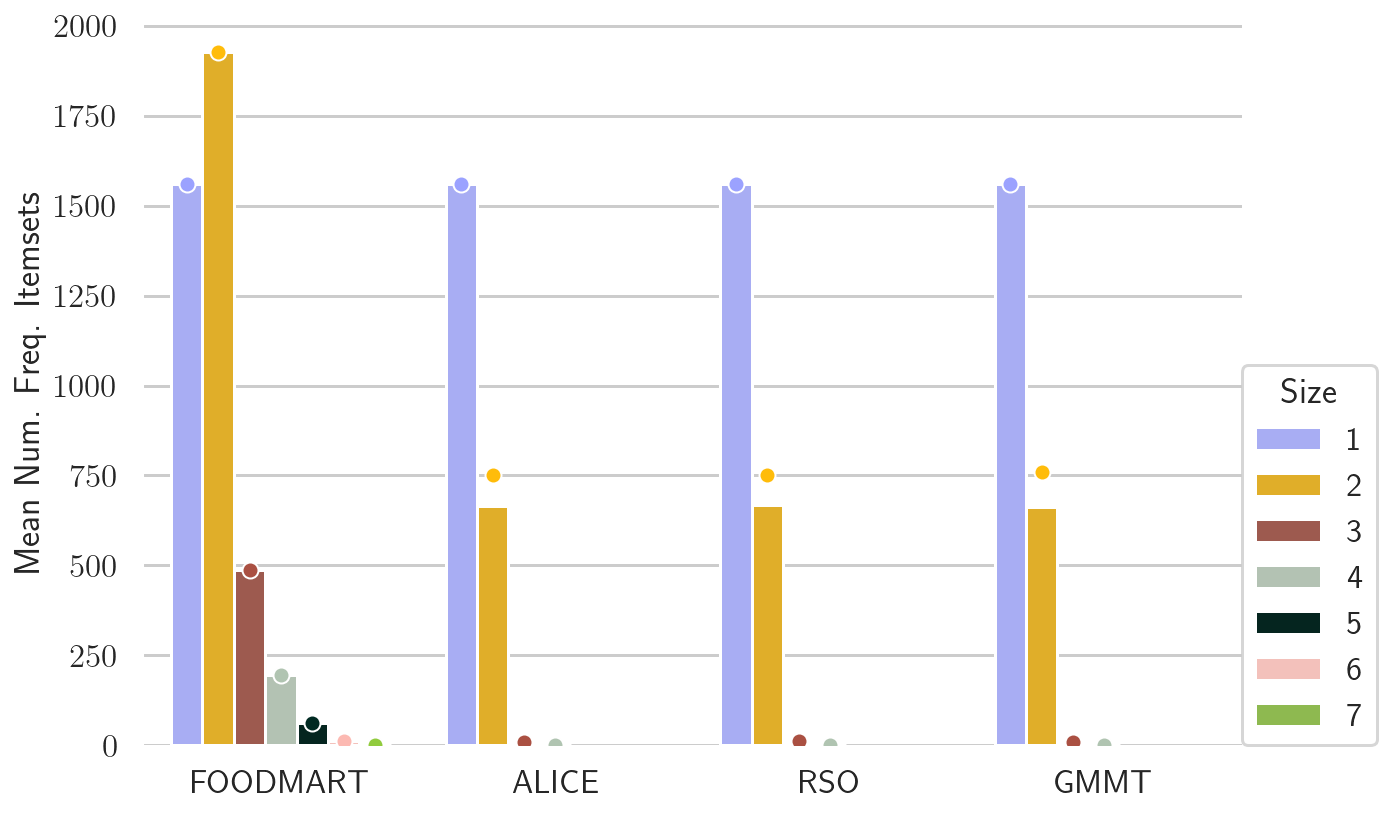

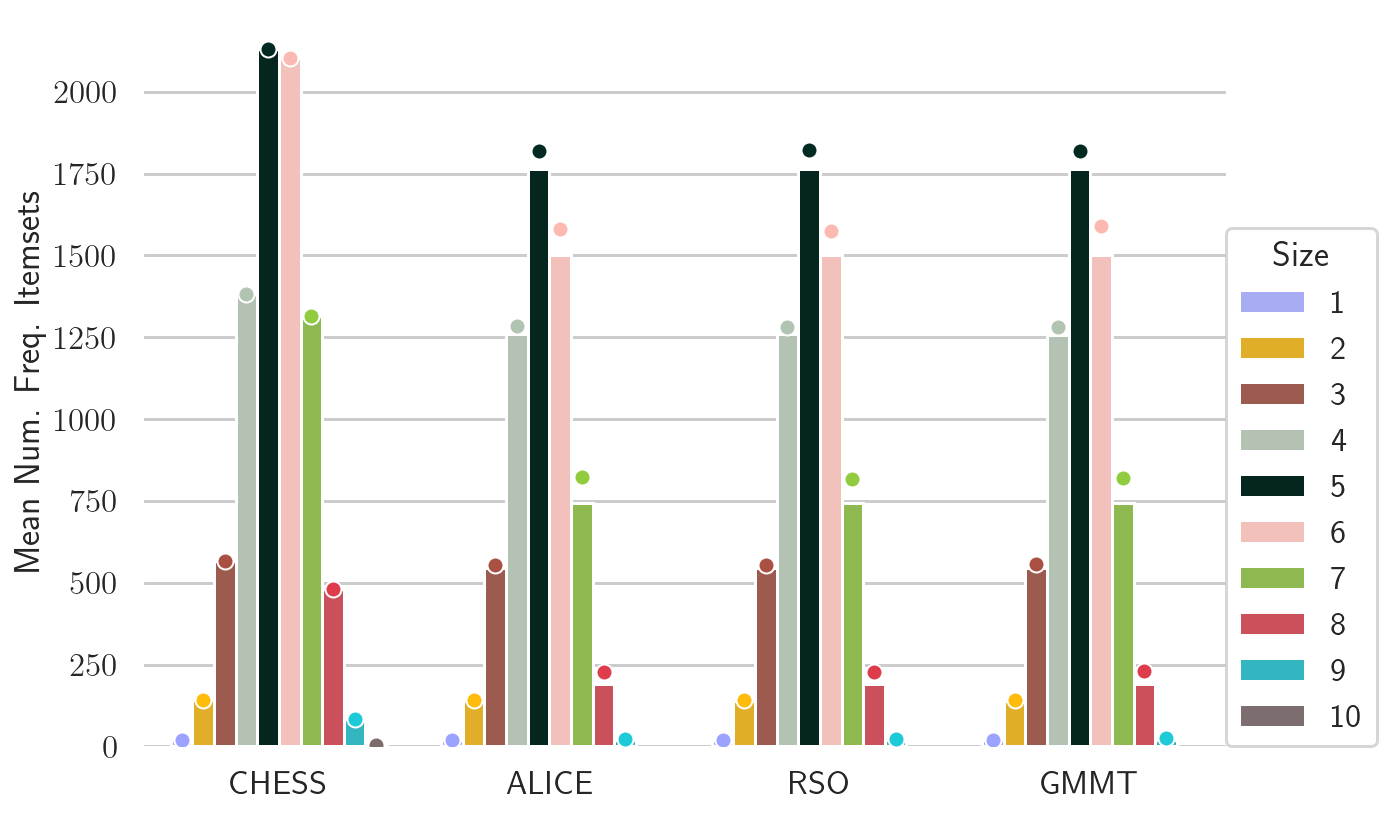

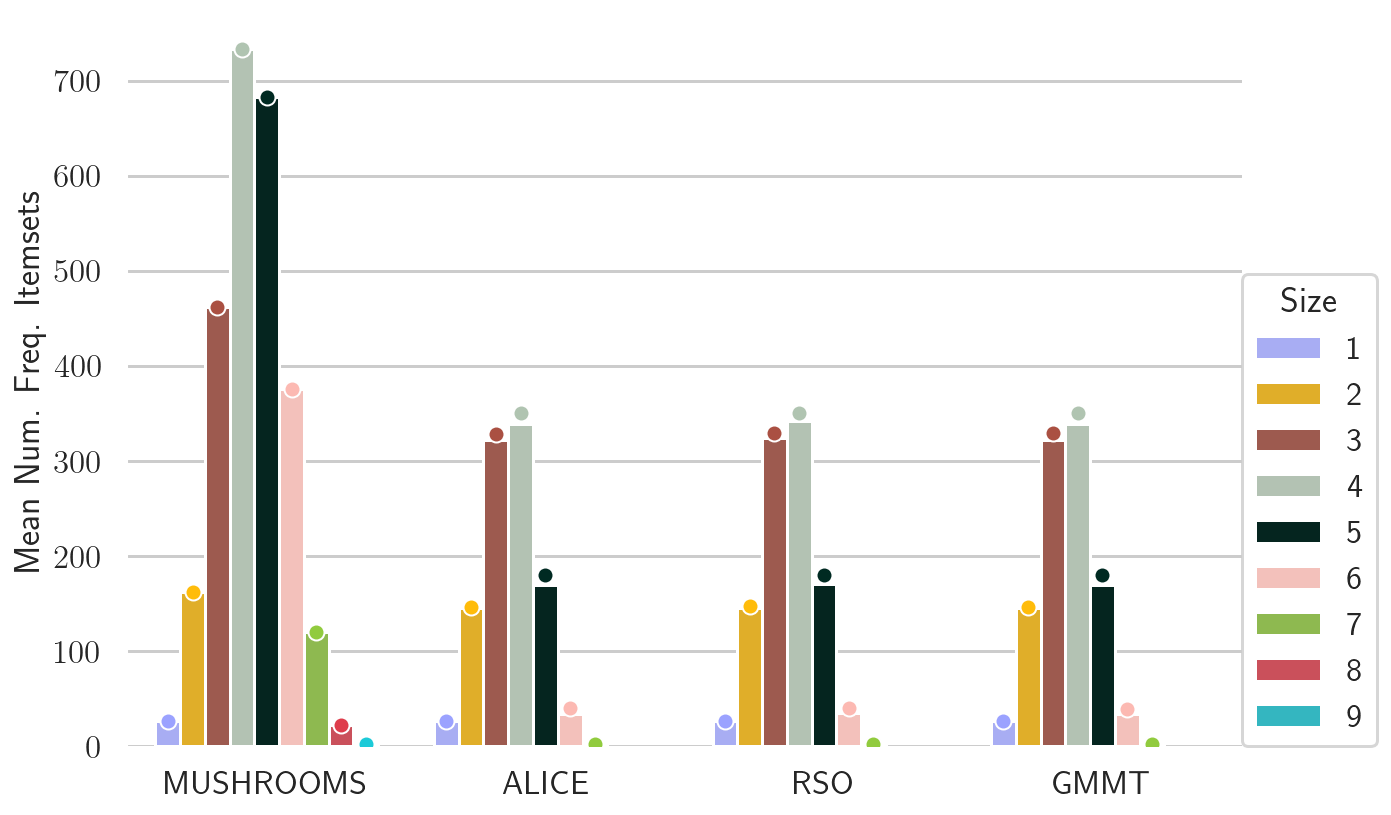

/Users/giulia/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


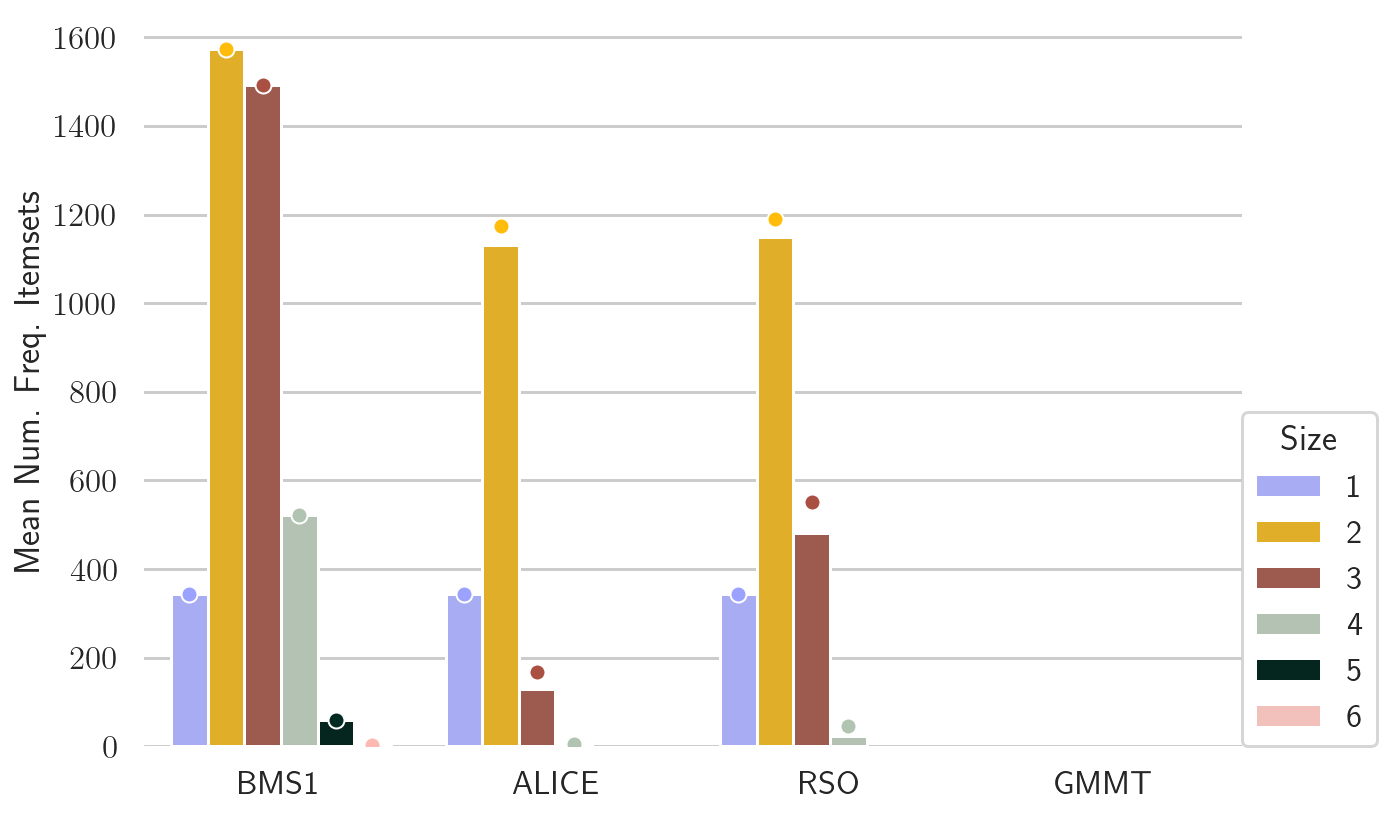

/Users/giulia/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


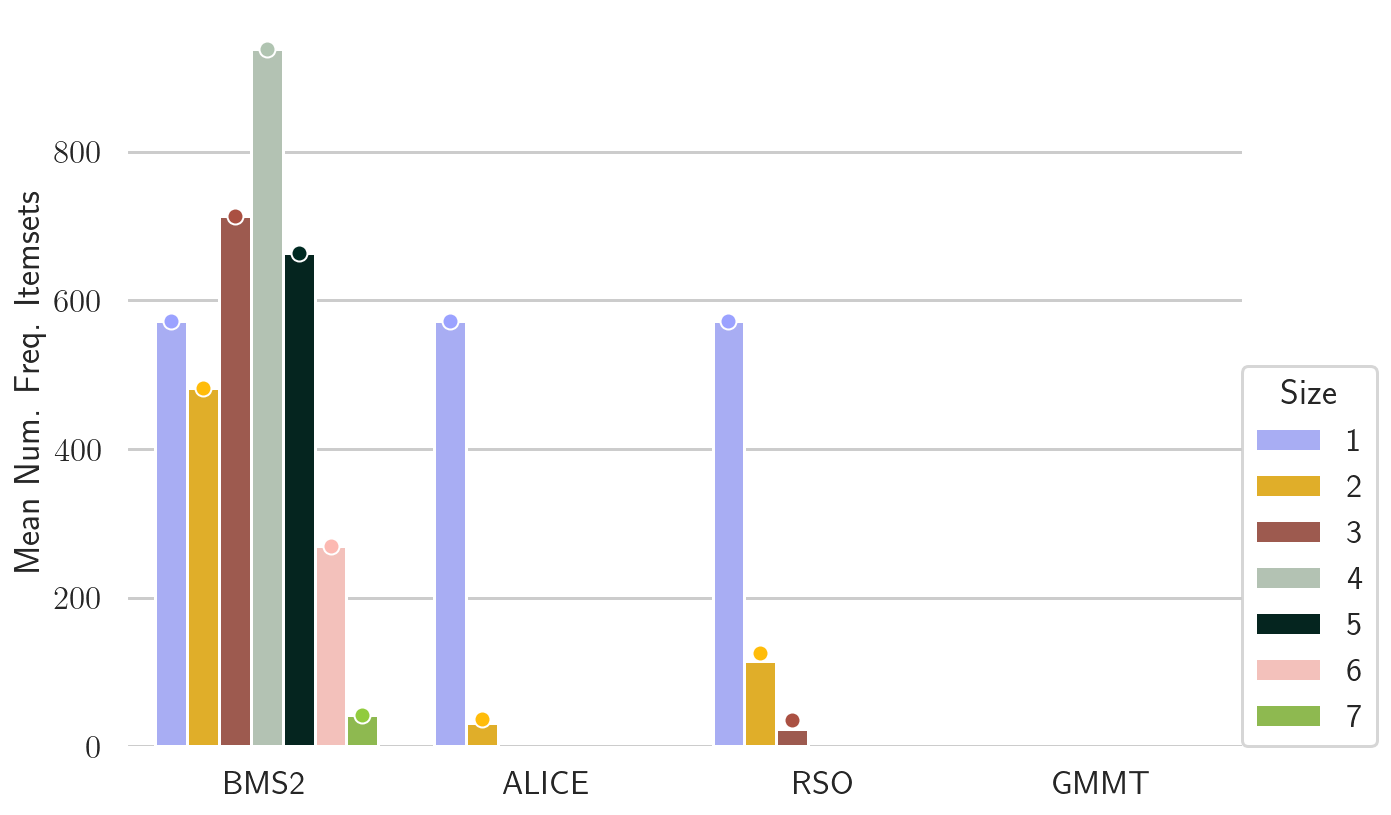

In [87]:
for db in db_config.keys():
    data = numfreq_df[numfreq_df['DataSet']==db]
    fig, ax = plt.subplots(figsize=(10,6))
    f = sns.barplot(data=data, x='Algorithm', y='med', hue='Size', 
                    palette=palette, order=[db.upper(), 'ALICE', 'RSO', 'GMMT'])
    h,l = f.get_legend_handles_labels()
    g = sns.swarmplot(data=data, x='Algorithm', y='max', hue='Size',
                      edgecolor='white', linewidth=1, label='_nolegend_',
                      order=[db.upper(), 'ALICE', 'RSO', 'GMMT'],
                      dodge=True, palette=palette,  size=8)
    g.legend().remove()
    ax.legend(h,l, title='Size', loc=(1,0))
    ax.set_ylabel('Mean Num. Freq. Itemsets')
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.savefig(fig_dir+f'{db}_numFreqItemsets.pdf')
    plt.show()

In [34]:
numfreq_df[(numfreq_df['Size']=='1') & 
           (numfreq_df['Algorithm']!='original')][['DataSet', 'Algorithm', 'pvalue']].dropna()

,DataSet,Algorithm,pvalue
7,foodmart,RSO,0.000459
11,foodmart,ALICE,0.000459
15,foodmart,GMMT,0.000459
10,chess,RSO,0.000459
19,chess,ALICE,0.000459
28,chess,GMMT,0.000459
9,mushrooms,RSO,0.000459
16,mushrooms,ALICE,0.000459
23,mushrooms,GMMT,0.000589
6,BMS1,RSO,0.000459


### Frequencies with different Samplers

In [37]:
with open(f'{result_dir}/itemset_support.pkl', 'rb') as f:
    itemset_df = pickle.load(f)

In [38]:
itemset_df['DataSet'] = itemset_df['DataSet'].apply(lambda x : x.split('/')[-1])

In [39]:
itemset_df = itemset_df[itemset_df['DataSet'] != 'retail']

Num of itemsets that are frequent for other samplers but this one

In [40]:
print('DATASET', 'ALICE', 'RSO', 'GMMT')
for db in itemset_df['DataSet'].unique():
    data = itemset_df[itemset_df['DataSet']==db]
    print(db,
          data['ALICE'].eq(0).sum(), 
          data['RSO'].eq(0).sum(),
          data['GMMT'].eq(0).sum())

DATASET ALICE RSO GMMT
BMS1 1256 421 4641
foodmart 236989 239112 233567
BMS2 174 0 813
chess 120 31 507
mushrooms 14 16 28


Num of times the frequency of a itemset is higher using this sampler than the other one

In [41]:
print('DATASET', 'ALICE>RSO', 'ALICE>GMMT', 'RSO>GMMT')
for db in itemset_df['DataSet'].unique():
    data = itemset_df[itemset_df['DataSet']==db]
    a_r = len(data[data['ALICE'] > data['RSO']])
    a_g = len(data[data['ALICE'] > data['GMMT']])
    r_g = len(data[data['RSO'] > data['GMMT']])
    print(db, a_r, a_g, r_g)

DATASET ALICE>RSO ALICE>GMMT RSO>GMMT
BMS1 1332 3385 4220
foodmart 196825 193344 193168
BMS2 0 639 813
chess 3205 3782 3903
mushrooms 520 548 592


## Significant Itemset Mining

In [42]:
result_dir = '../output/significantItemsets'

In [43]:
db_config = {'foodmart':'18319-2048-128-3.0E-4-0.05-32-0',
             'chess':'118252-2048-128-0.8-0.05-32-0',
             'mushrooms':'193568-1568-128-0.3-0.05-32-0',
             'BMS1':'299278-1568-128-0.001-0.05-32-0',
             'BMS2':'716556-1568-128-0.002-0.05-32-0'}

In [44]:
results = []
for db,conf in db_config.items():
    for p in combinations(samplers, 2):
        try:
            fileA = f'{result_dir}/{db}-{p[0]}-{conf}.json'
            fileB = f'{result_dir}/{db}-{p[1]}-{conf}.json'
            num_a, num_b, jac, a_diff_b, b_diff_a, a_in_b, b_in_a = sig.analyze(fileA, fileB)
            results.append([db, p[0], p[1], jac, a_diff_b, num_a, a_in_b])
            results.append([db, p[1], p[0], jac, b_diff_a, num_b, b_in_a])
        except Exception as e:
            pass
sig_df = pd.DataFrame(results)
sig_df.columns = ['DataSet', 'Algorithm', 'Other', 'Jaccard', 
                  'Difference', 'NumSignItemsets', 'isSubset']
sig_df['Algorithm'] = sig_df['Algorithm'].apply(lambda x: sampler_names[x])
sig_df['Other'] = sig_df['Other'].apply(lambda x: sampler_names[x])

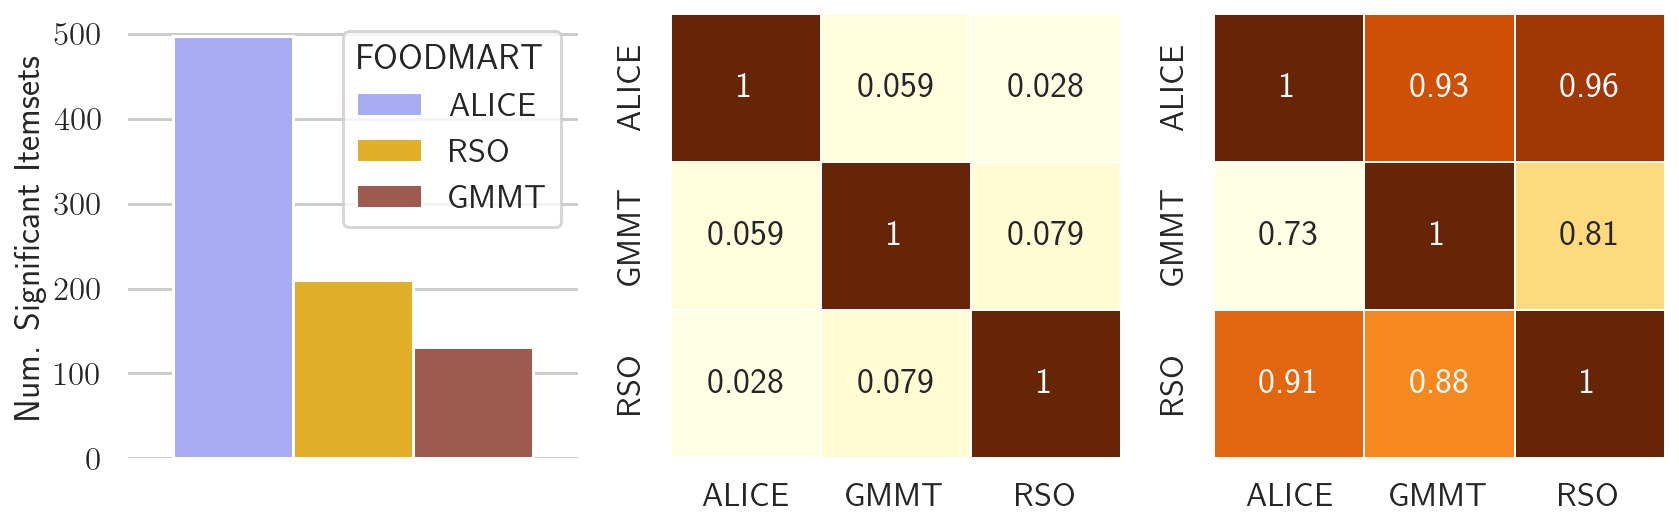

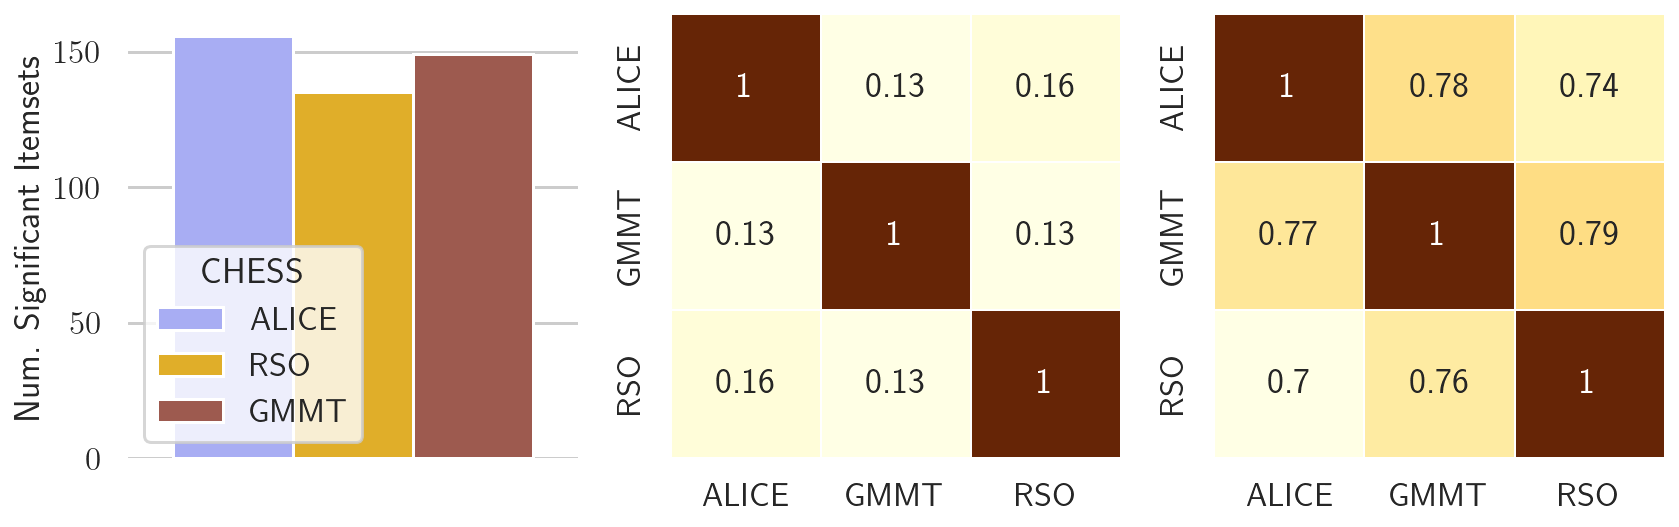

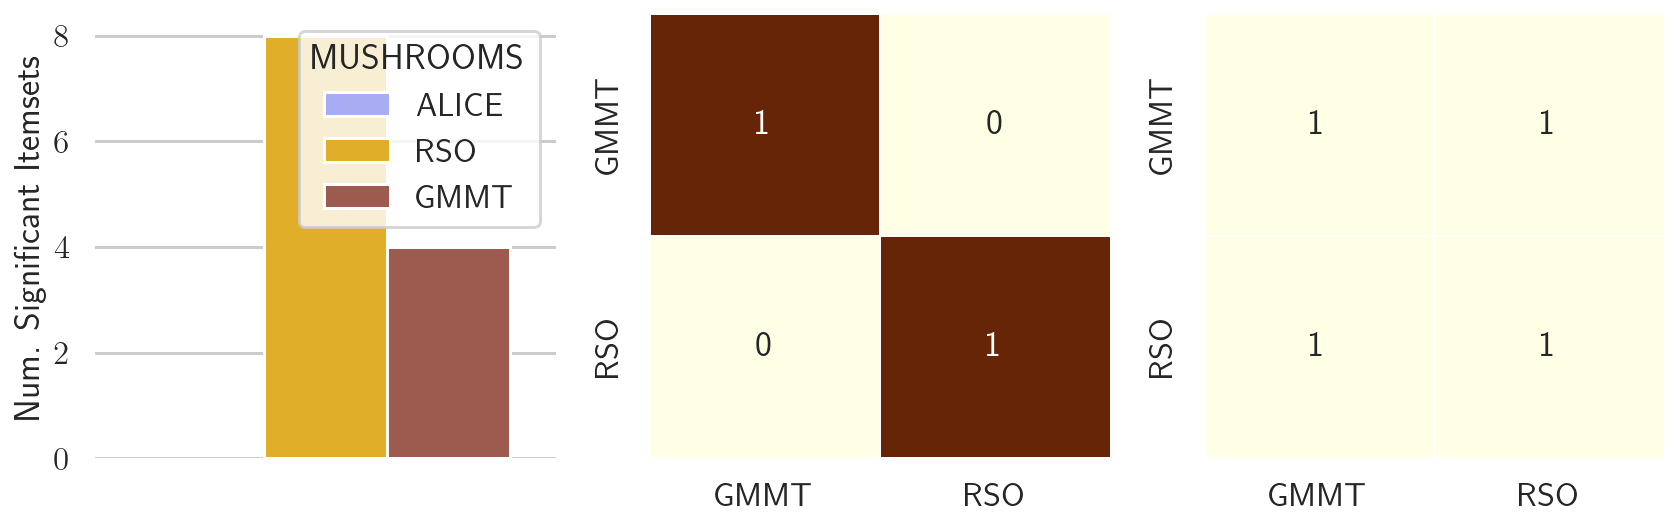

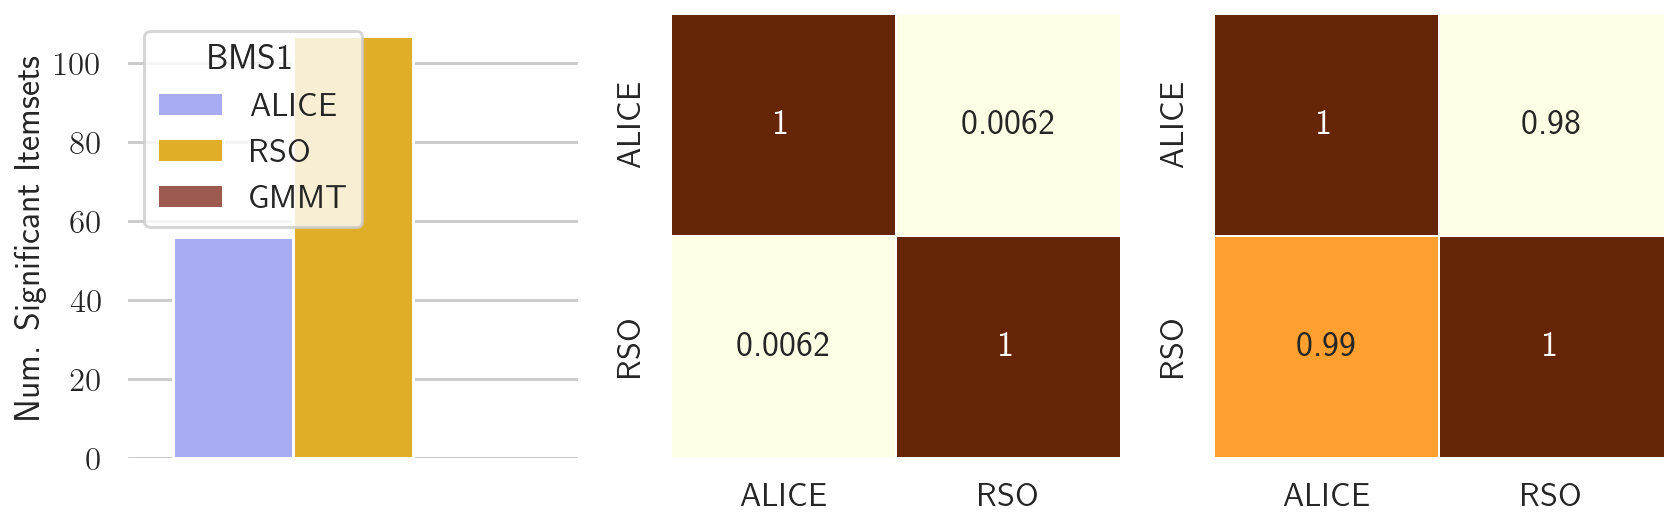

In [46]:
for dataset in sig_df['DataSet'].unique():
    data = sig_df[sig_df['DataSet']==dataset]
    if data.empty or data['NumSignItemsets'].sum()==0: continue

    fig, ax = plt.subplots(1,3,figsize=(12,4))
    
    # num significant itemsets
    sns.barplot(data=data, x='DataSet', hue='Algorithm',
                palette=palette, y='NumSignItemsets', 
                hue_order=['ALICE', 'RSO', 'GMMT'], ax=ax[0])
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].legend(title=dataset.upper())
    ax[0].set_ylabel('Num. Significant Itemsets')
    ax[0].set_xlabel('')
    ax[0].set_xticklabels('')

    sns.heatmap(data=data.pivot('Algorithm', 'Other', 'Jaccard').fillna(1),
                annot=True, linewidths=1, cmap="YlOrBr", cbar=False, ax=ax[1])
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    
    sns.heatmap(data=data.pivot('Algorithm', 'Other', 'Difference').fillna(1),
                annot=True, linewidths=1, cmap="YlOrBr", cbar=False, ax=ax[2])
    ax[2].set_xlabel('')
    ax[2].set_ylabel('')
    plt.tight_layout()
#     plt.savefig(fig_dir+f'{dataset}_sigFreqItemsets.pdf')
    plt.show()

## BJDM

- We generated 1000 samples.
- We performed 1000 steps.
- We created a BJDM vector of size maxRowSum * maxColSum, concatenating the values of the BJDM.
- We normalized the vector by the number of edges.
- Every 100 steps, we stored the EarthMoversDistance between the original BJDM vector and the current one.

In [47]:
result_dir = '../output/bjdm'
samplers = ['caterpillars.samplers.NaiveBJDMSampler',
            'diffusr.samplers.GmmtSampler']

In [48]:
dfs = []
for db in ['chess', 'foodmart', 'mushrooms', 'BMS2']:
    file_name = f'{result_dir}/{db}-10000-1000-0.json'
    with open(file_name) as f:
        stats = json.load(f)['runtimeStats']
        for sampler in samplers:
            samplers_stats = stats[sampler]
            obs = len(samplers_stats["minDist"])
            distances = list()
            distances.extend(samplers_stats["minDist"])
            distances.extend(samplers_stats["c10Dist"])
            distances.extend(samplers_stats["q1Dist"])
            distances.extend(samplers_stats["meanDist"])
            distances.extend(samplers_stats["q3Dist"])
            distances.extend(samplers_stats["c90Dist"])
            distances.extend(samplers_stats["maxDist"])
            tmp = pd.DataFrame(distances)
            tmp['DataSet'] = db
            tmp['Sampler'] = sampler
            dfs.append(tmp)

In [49]:
bjdm_df = pd.concat(dfs)

In [50]:
bjdm_df.columns = ['Distance', 'DataSet', 'Sampler']

In [51]:
bjdm_df['Sampler'] = bjdm_df['Sampler'].apply(lambda x: sampler_names[x])
bjdm_df['DataSet'] = bjdm_df['DataSet'].apply(lambda x: x.upper())

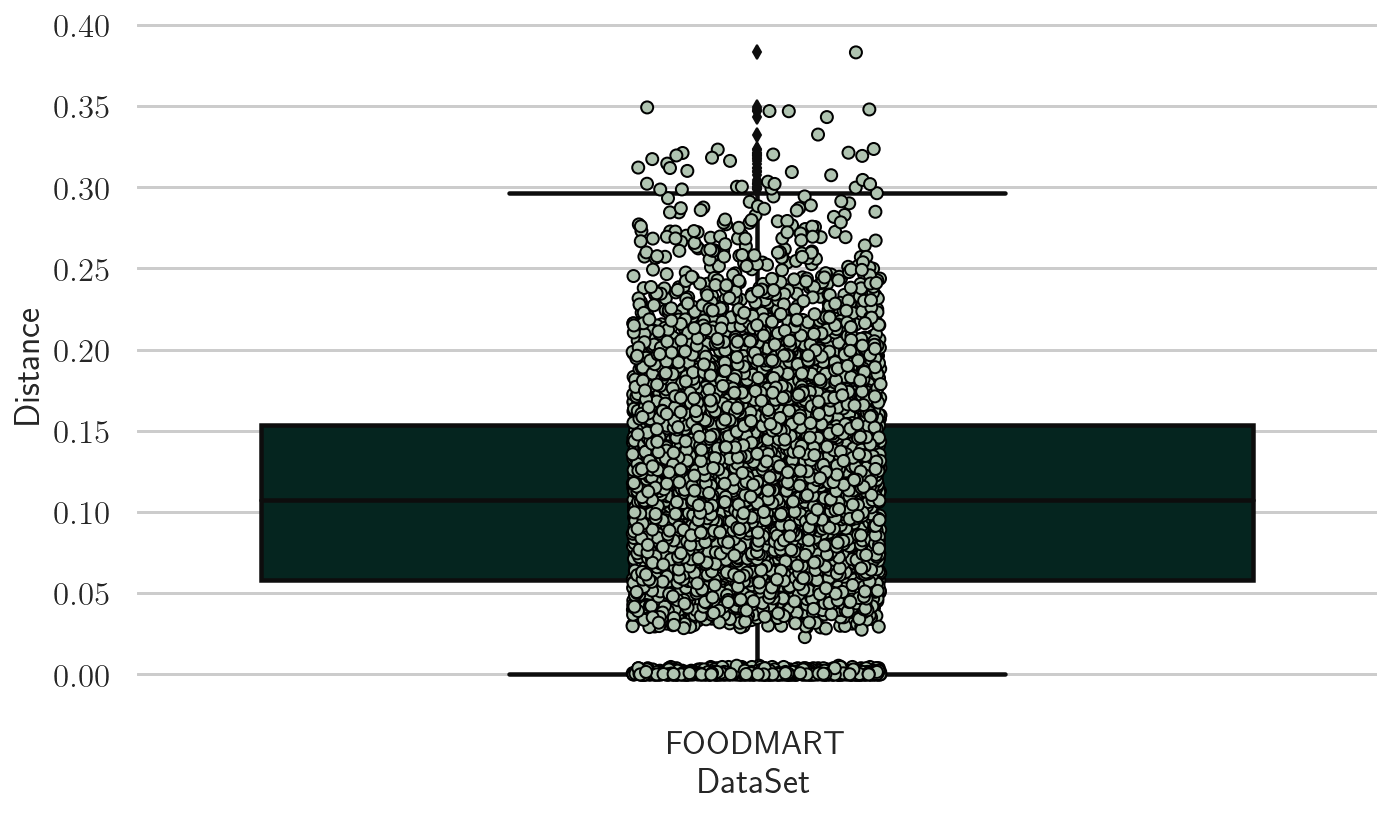

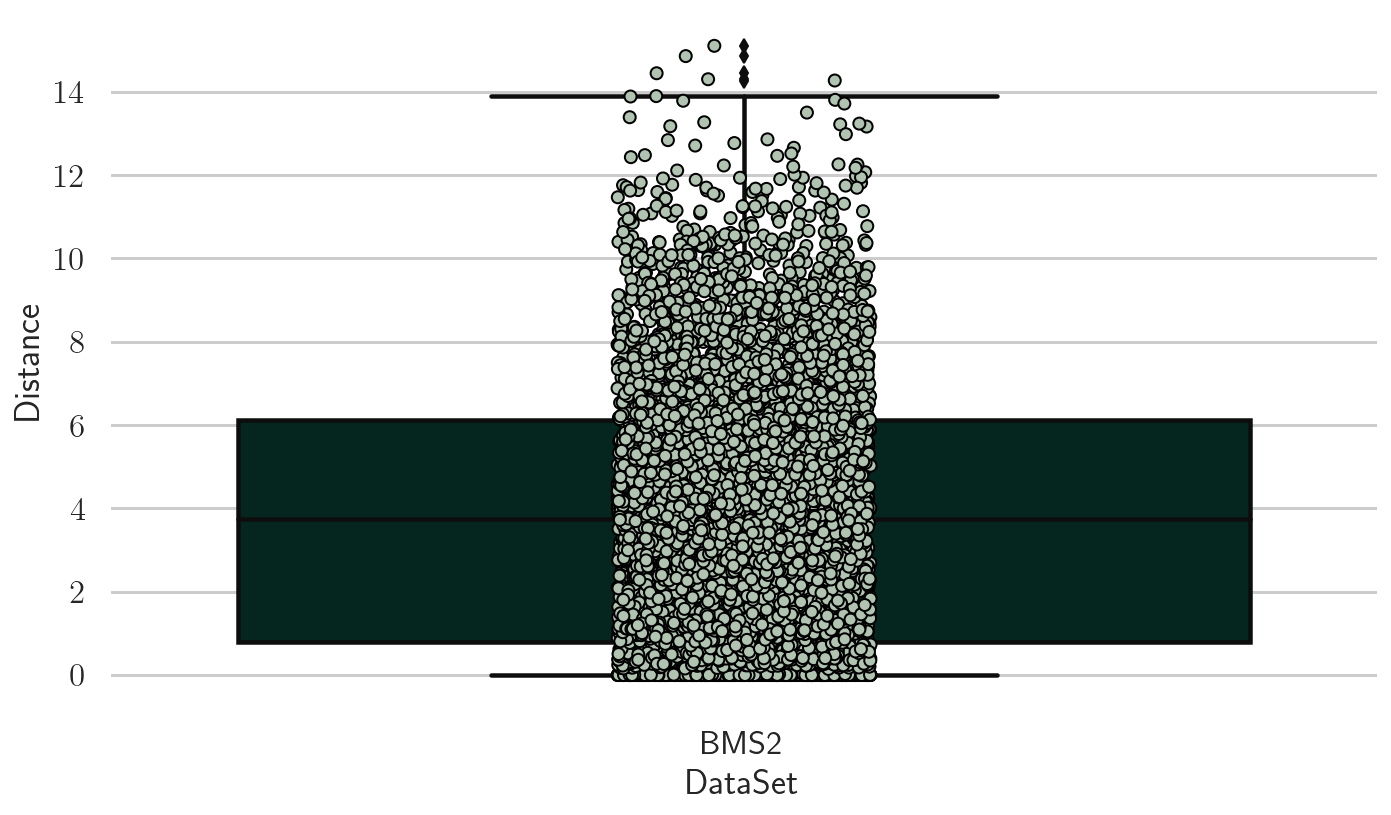

In [53]:
for db in bjdm_df['DataSet'].unique():
    data = bjdm_df[(bjdm_df['Sampler']=='GMMT') &
                   (bjdm_df['DataSet']==db)]
    if data['Distance'].sum() > 0:
        fig, ax = plt.subplots(figsize=(10,6))
        sns.boxplot(data=data, x='DataSet', y='Distance',
                    dodge=True, palette=palette[4:], ax=ax)
        sns.stripplot(data=data, x='DataSet', y='Distance',
                      edgecolor='black', size=6, linewidth=1,
                      palette=palette[3:], ax=ax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        plt.tight_layout()
        # plt.savefig(fig_dir+f'{db}_numFreqItemsets.pdf')
        plt.show()